In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
tf.__version__

'2.10.1'

In [2]:
(X_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()

8


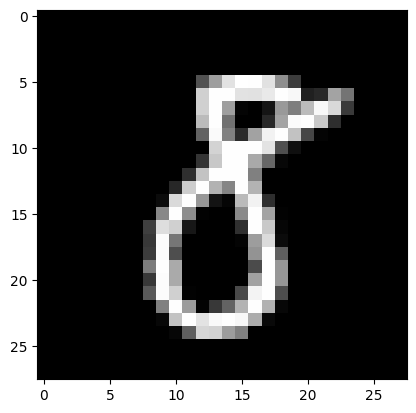

In [5]:
i = np.random.randint(0, X_train.shape[0])
print(y_train[i])
plt.imshow(X_train[i], cmap='gray')

In [8]:
X_train_reshape = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_train_normalized = (X_train - 127.5) / 127.5
buffer_size = X_train.shape[0]
batch_size = 256

In [9]:
X_train = tf.data.Dataset.from_tensor_slices(X_train_normalized).shuffle(buffer_size).batch(batch_size)

In [12]:
def build_generator():
    network = tf.keras.Sequential()
    network.add(tf.keras.layers.Dense(units=7*7*256, 
                                      use_bias=False, 
                                      input_shape=(100,)))
    network.add(tf.keras.layers.BatchNormalization())
    network.add(tf.keras.layers.LeakyReLU())
    
    network.add(tf.keras.layers.Reshape((7,7,256)))
    
    network.add(tf.keras.layers.Conv2DTranspose(filters=128, 
                                                kernel_size=(5,5), 
                                                padding='same', 
                                                use_bias=False))
    network.add(tf.keras.layers.BatchNormalization())
    network.add(tf.keras.layers.LeakyReLU())
    
    network.add(tf.keras.layers.Conv2DTranspose(filters=64, 
                                                kernel_size=(5,5), 
                                                padding='same', 
                                                strides=(2,2), 
                                                use_bias=False))
    network.add(tf.keras.layers.LeakyReLU())
    
    network.add(tf.keras.layers.Conv2DTranspose(filters=1, 
                                                kernel_size=(5,5), 
                                                padding='same', 
                                                strides=(2,2), 
                                                use_bias=False, 
                                                activation='tanh'))
    
    network.summary()
    
    return network

In [13]:
generator = build_generator()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)       

In [14]:
generator.input

<KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'dense_1_input')>

In [15]:
noise = tf.random.normal([1, 100])
noise

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[ 1.7257448e-01,  5.1100934e-01,  1.2248344e+00, -8.2396287e-01,
        -9.7427773e-01,  8.2524902e-01, -9.1898578e-01, -9.8694539e-01,
        -6.5056992e-01, -1.5882249e-01, -1.9444722e-01,  3.6745447e-01,
        -4.4413078e-01, -5.9604013e-01,  9.9416339e-01, -7.7913392e-01,
         2.4075364e-01, -6.8256503e-01,  4.4907328e-01, -1.9790164e+00,
         5.4922861e-01, -8.0570000e-01, -1.9125105e-01, -1.3080238e-01,
        -1.2576787e+00,  6.1768347e-01,  1.4948925e-02, -1.0980378e+00,
        -5.1285166e-01,  5.2909832e-02, -1.9836419e+00,  5.9567487e-01,
        -7.0854366e-01,  9.2267239e-01,  8.6425029e-02,  8.0793363e-01,
        -1.3289311e+00,  1.3679538e+00, -3.5862690e-01, -3.6671025e-01,
        -8.5239470e-01,  1.3808565e-01,  2.9672372e-01,  4.8191255e-01,
        -4.5364702e-01, -1.2725142e+00,  3.5043243e-01,  2.0792893e-01,
        -1.2164689e+00, -1.5079726e-01, -1.3413571e+00, -1.1209694e+00,
         1.557

In [16]:
generated_image = generator(noise, training=False)

In [17]:
generated_image.shape

TensorShape([1, 28, 28, 1])

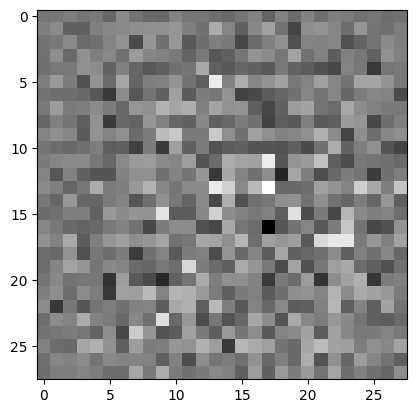

In [18]:
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [19]:
def build_discriminator():
    network = tf.keras.Sequential()
    
    network.add(tf.keras.layers.Conv2D(filters=64, 
                                       kernel_size=(5,5),
                                       strides=(2,2), 
                                       padding='same', 
                                       input_shape=[28,28,1]))
    network.add(tf.keras.layers.LeakyReLU())
    network.add(tf.keras.layers.Dropout(0.3))
    
    network.add(tf.keras.layers.Conv2D(filters=128, 
                                       kernel_size=(5,5),
                                       strides=(2,2), 
                                       padding='same'))
    network.add(tf.keras.layers.LeakyReLU())
    network.add(tf.keras.layers.Dropout(0.3))
    
    network.add(tf.keras.layers.Flatten())
    network.add(tf.keras.layers.Dense(1))
    
    network.summary()
    
    return network

In [20]:
discriminator = build_discriminator()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [21]:
discriminator.input

<KerasTensor: shape=(None, 28, 28, 1) dtype=float32 (created by layer 'conv2d_input')>

In [22]:
discriminator(generated_image, training=False)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00174019]], dtype=float32)>

In [23]:
tf.sigmoid(-0.00081761)

<tf.Tensor: shape=(), dtype=float32, numpy=0.49979565>

In [24]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [27]:
def discriminator_loss(expected_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(expected_output), expected_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [28]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [29]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

In [30]:
epochs = 100
noise_dimension = 100
number_of_images = 16

In [31]:
@tf.function
def train(images):
    noise = tf.random.normal([batch_size, noise_dimension])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        expected_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(expected_output, fake_output)
    
    generator_gradient = gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(generator_gradient, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradient, discriminator.trainable_variables))
    

In [36]:
tf.config.run_functions_eagerly(True)
X_train_batch = X_train.as_numpy_iterator().next()
train(X_train_batch)

In [37]:
test_images = tf.random.normal([number_of_images, noise_dimension])
test_images.shape

TensorShape([16, 100])

In [38]:
def train_gan(dataset, epochs, test_images):
    for epoch in range(epochs):
        for image_batch in dataset:
            train(image_batch)
        print('Epoch: ', epoch+1)
        generated_images = generator(test_images, training=False)
        fig = plt.figure(figsize=(10,10))
        for i in range(generated_images.shape[0]):
            plt.subplot(4,4,i+1)
            plt.imshow(generated_images[i, :, :, 0]*127.5+127.5, cmap='gray')
            plt.axis('off')
        plt.show()

Epoch:  1


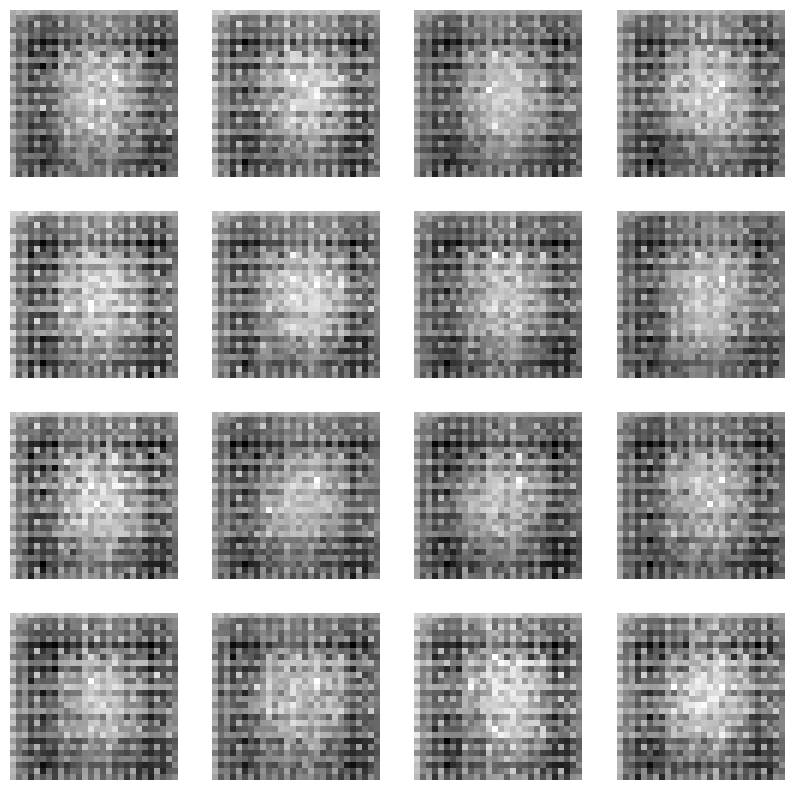

Epoch:  2


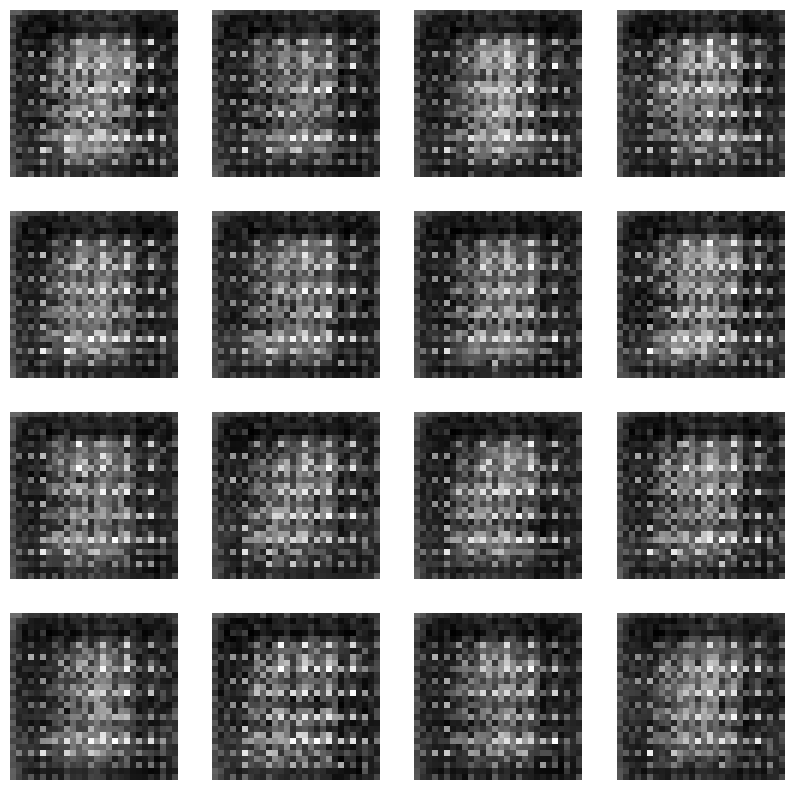

Epoch:  3


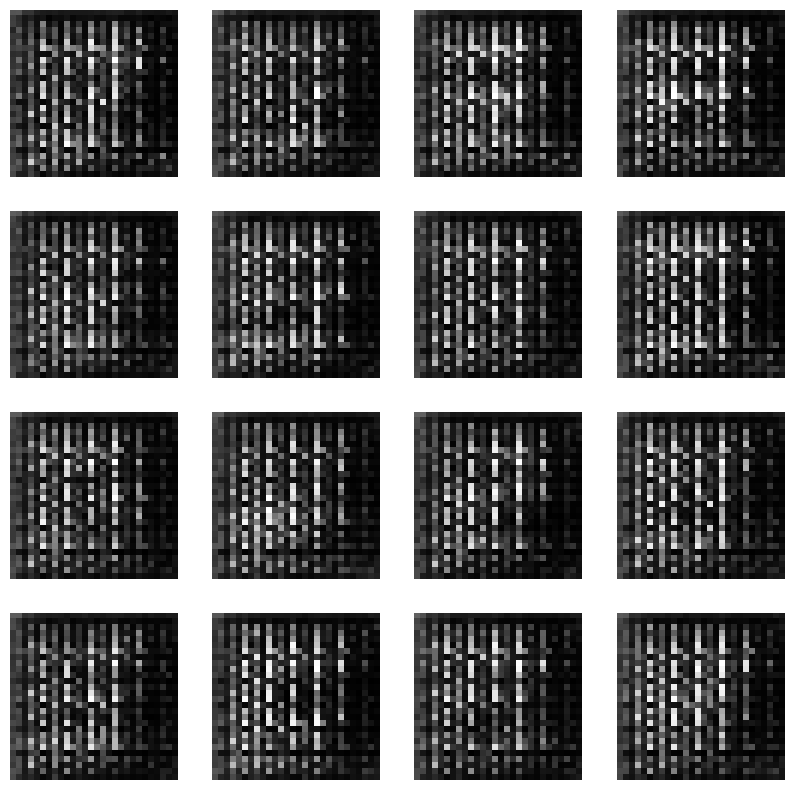

Epoch:  4


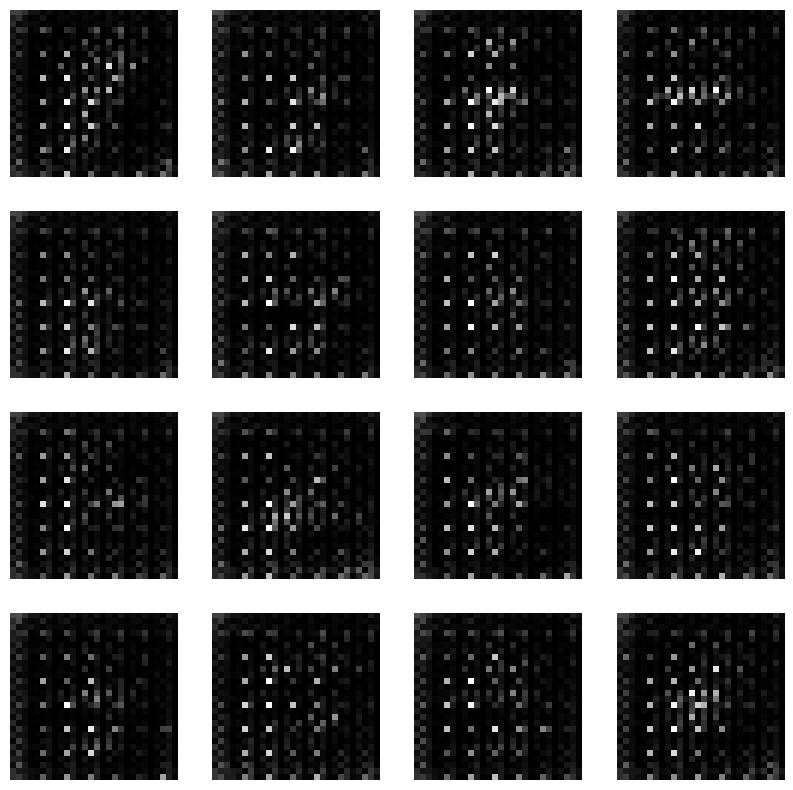

Epoch:  5


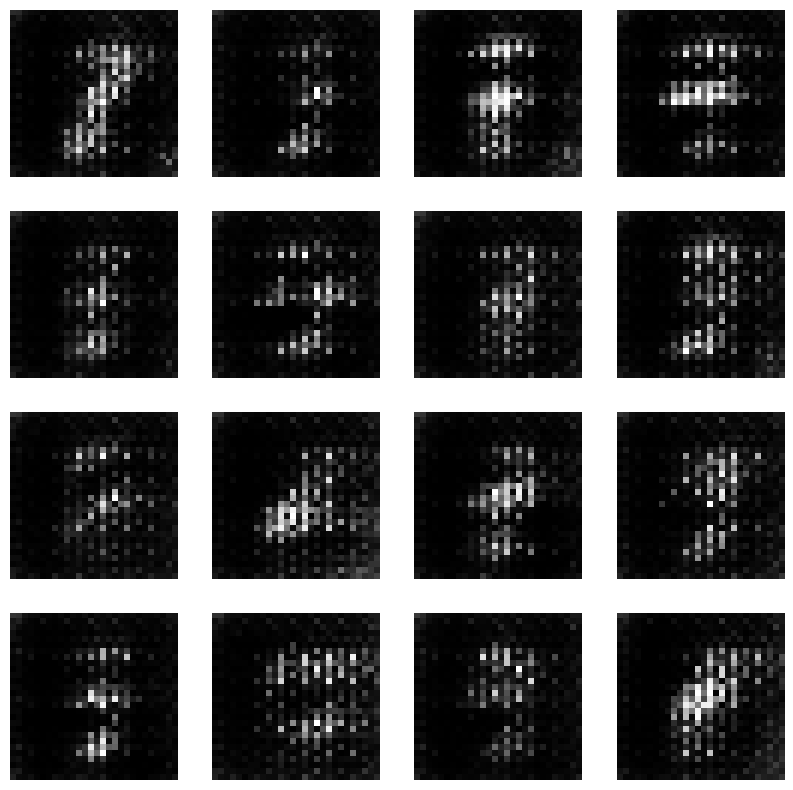

Epoch:  6


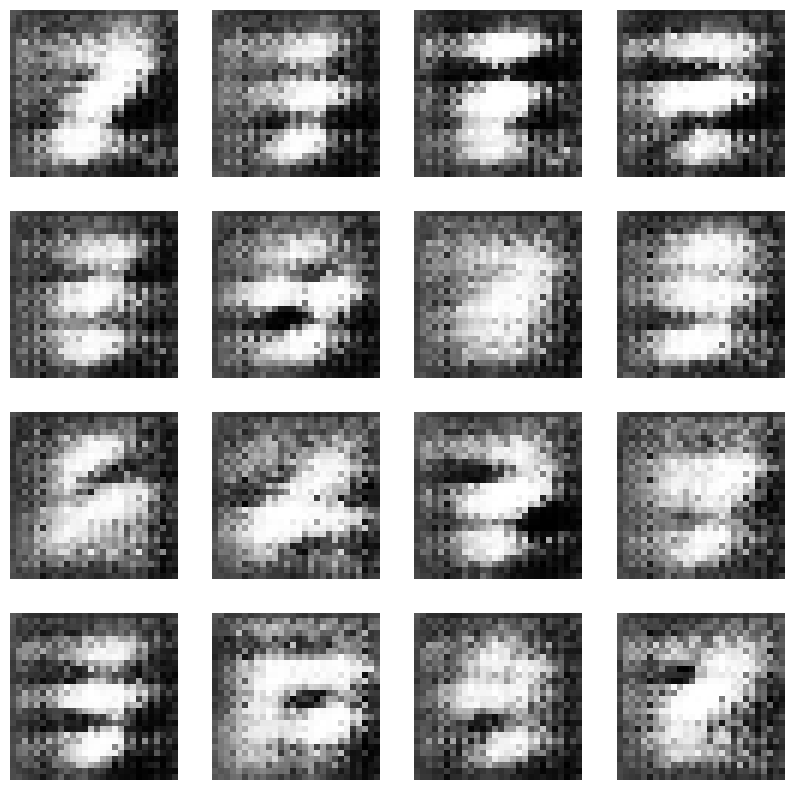

Epoch:  7


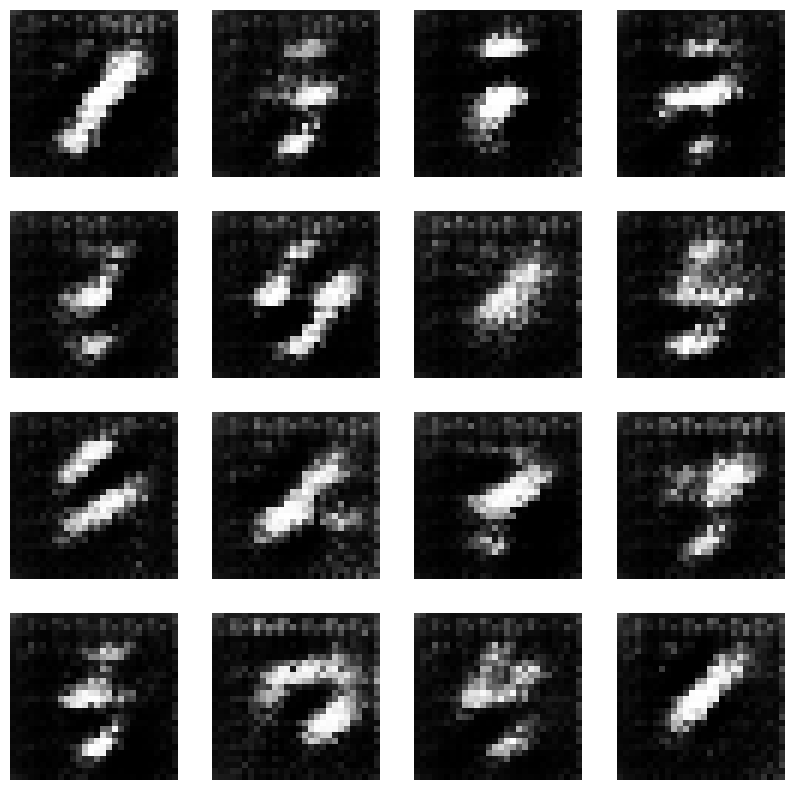

Epoch:  8


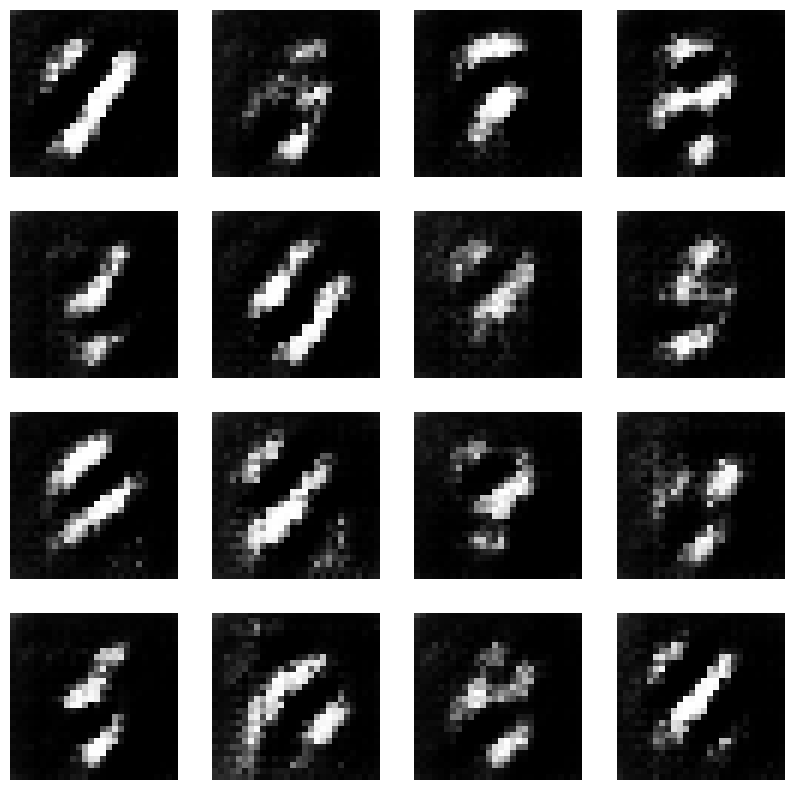

Epoch:  9


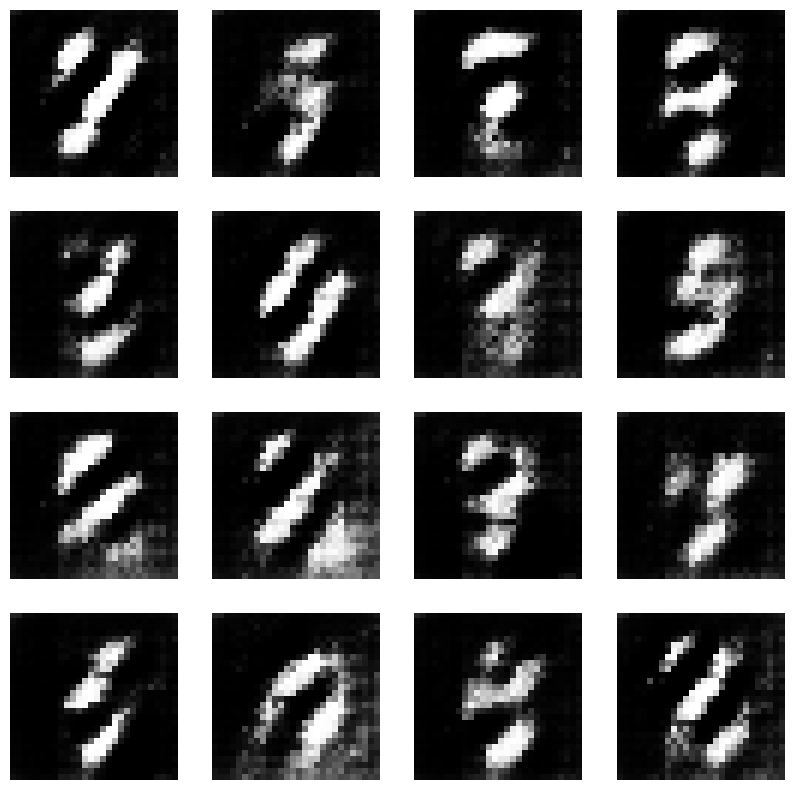

Epoch:  10


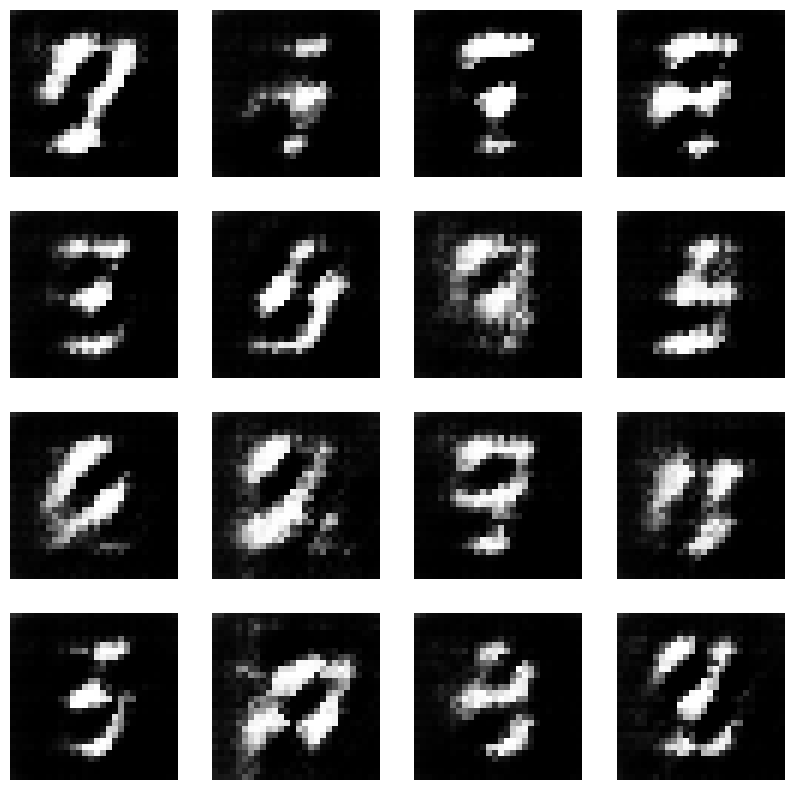

Epoch:  11


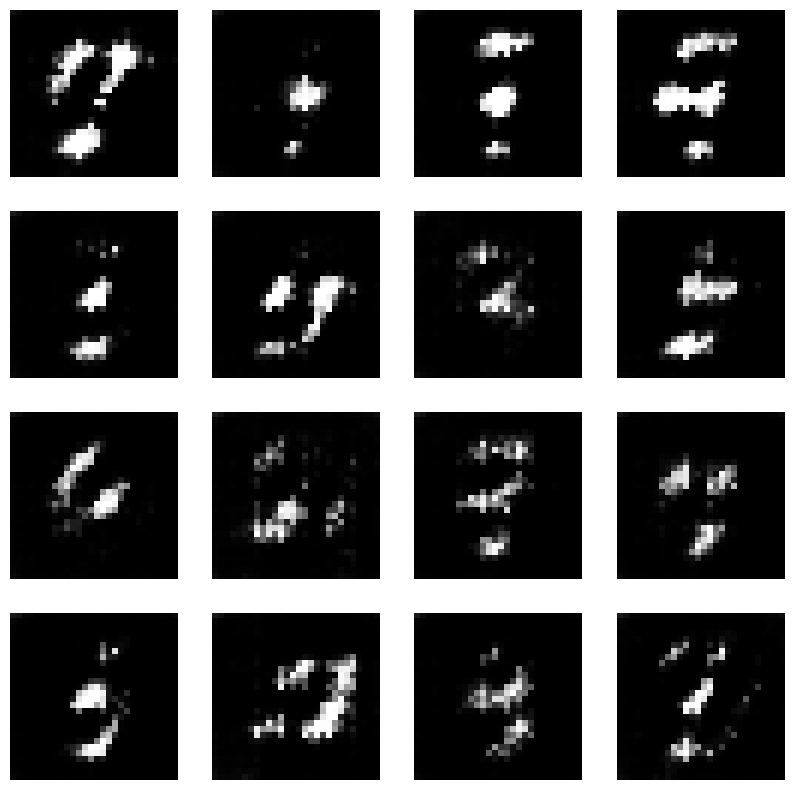

Epoch:  12


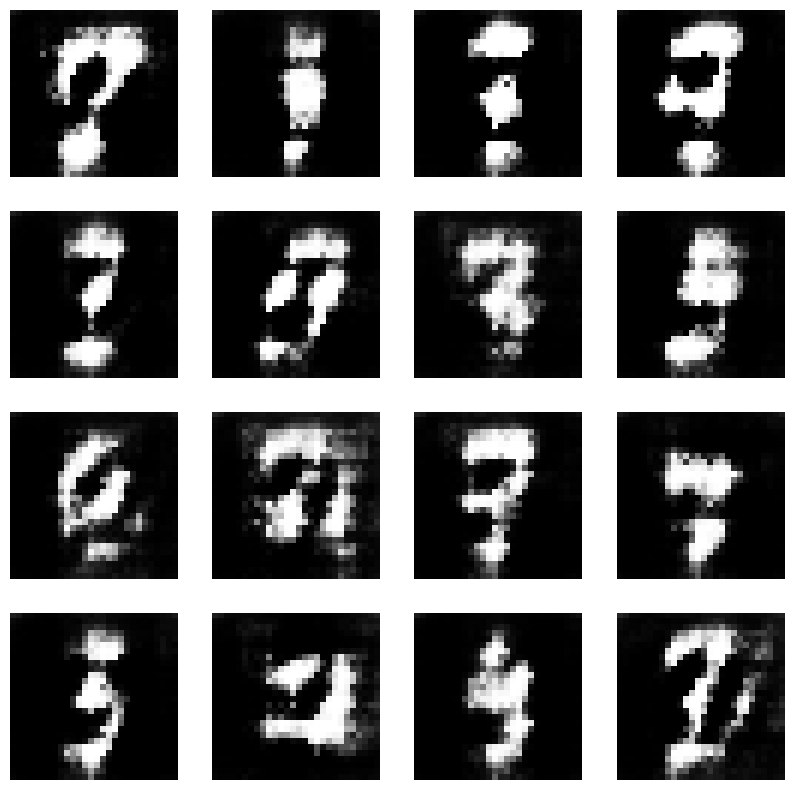

Epoch:  13


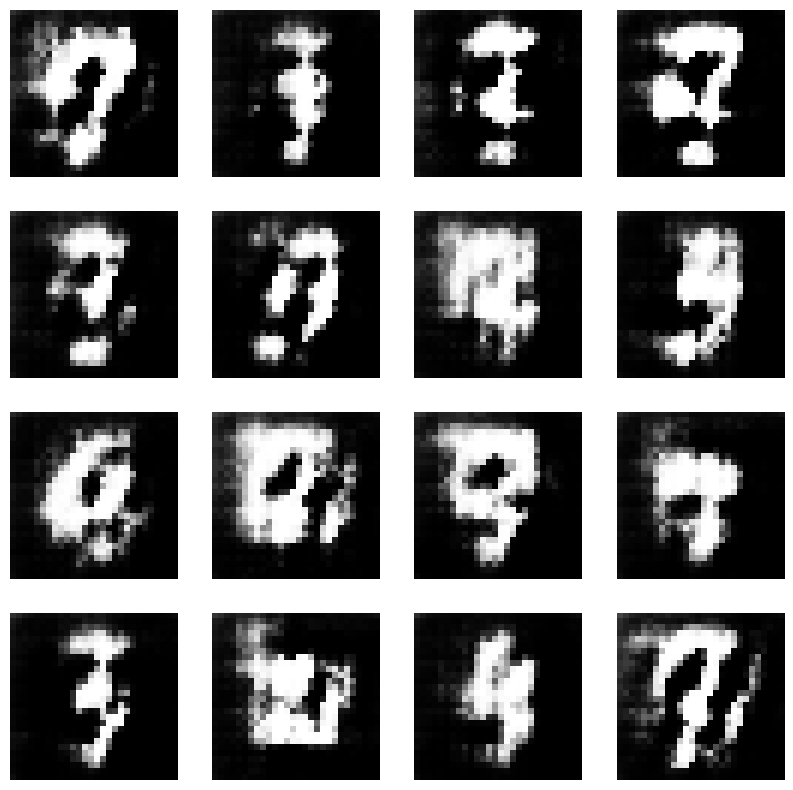

Epoch:  14


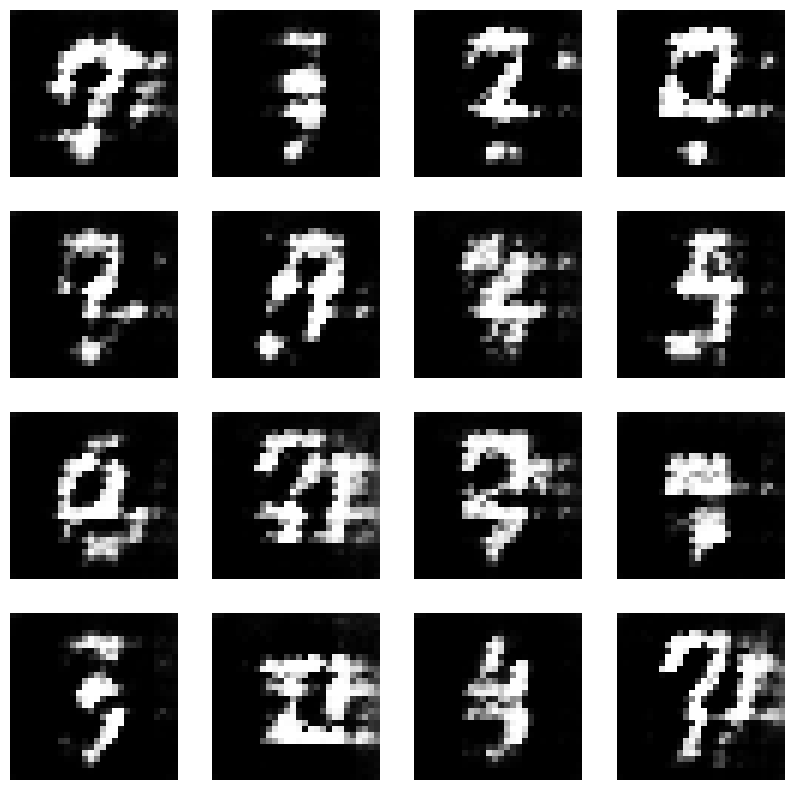

Epoch:  15


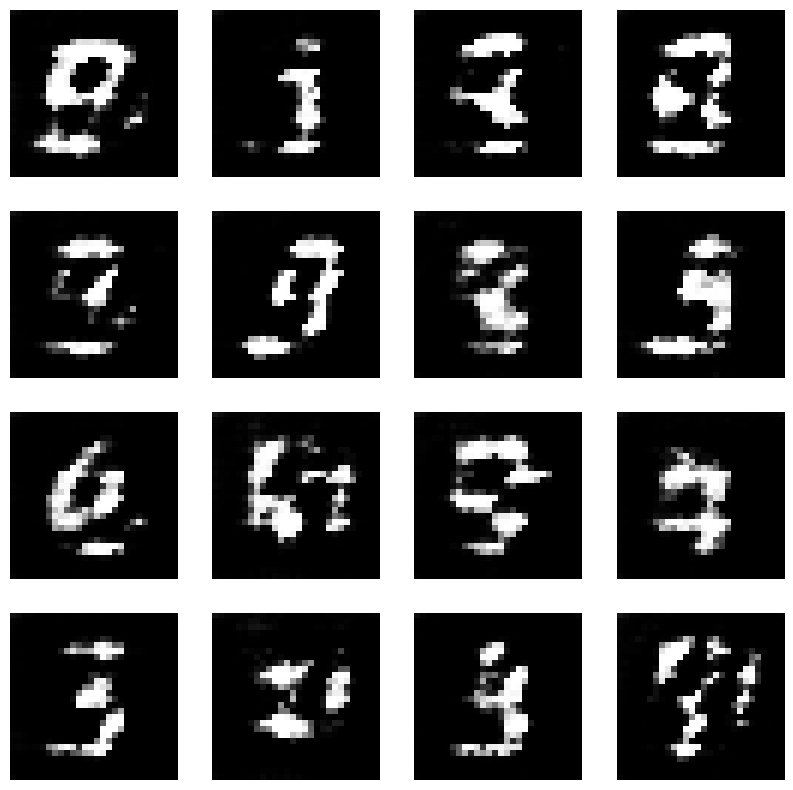

Epoch:  16


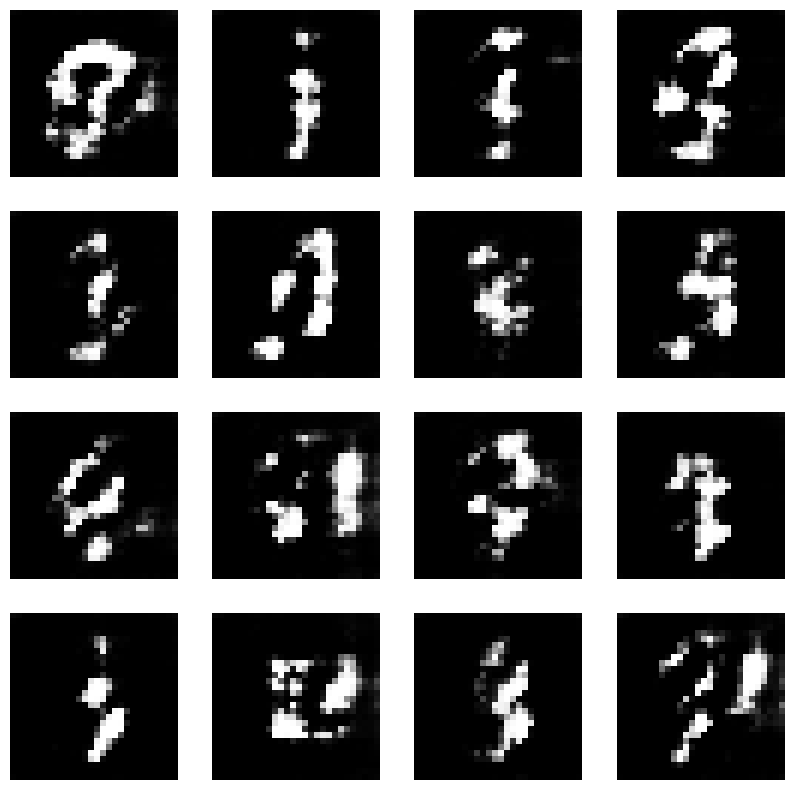

Epoch:  17


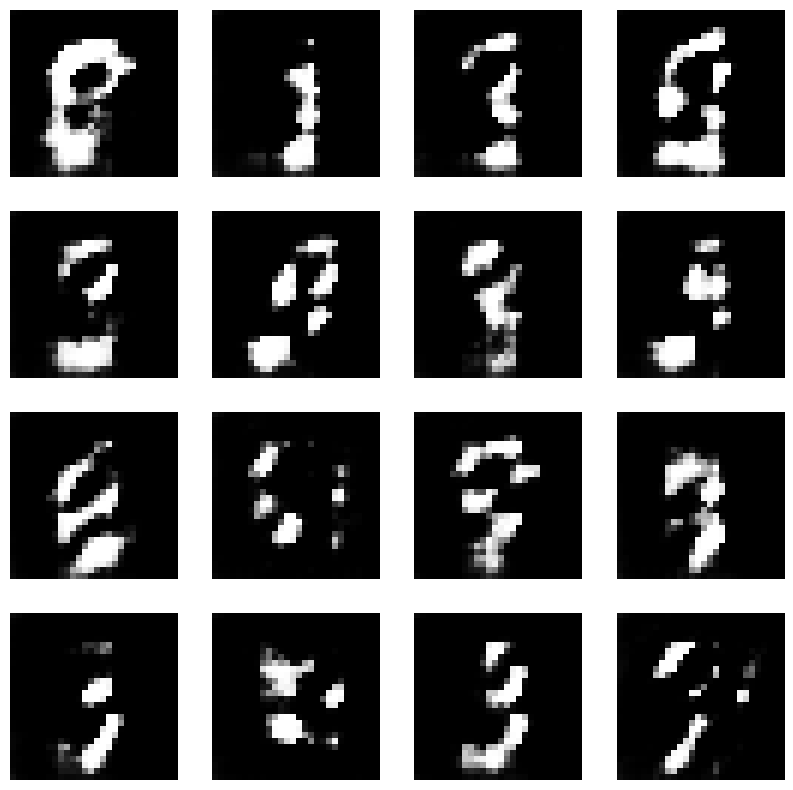

Epoch:  18


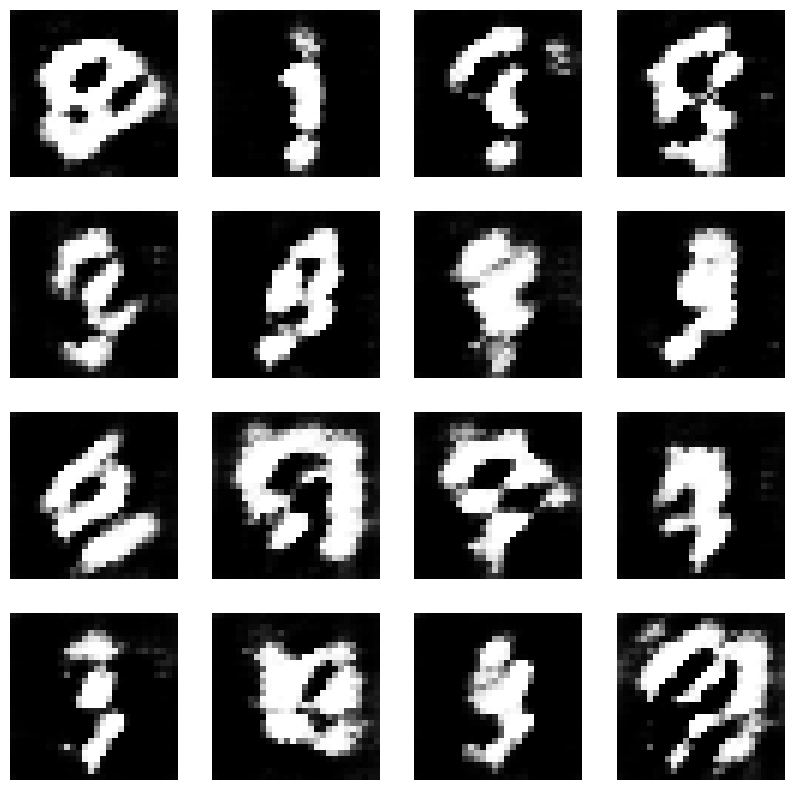

Epoch:  19


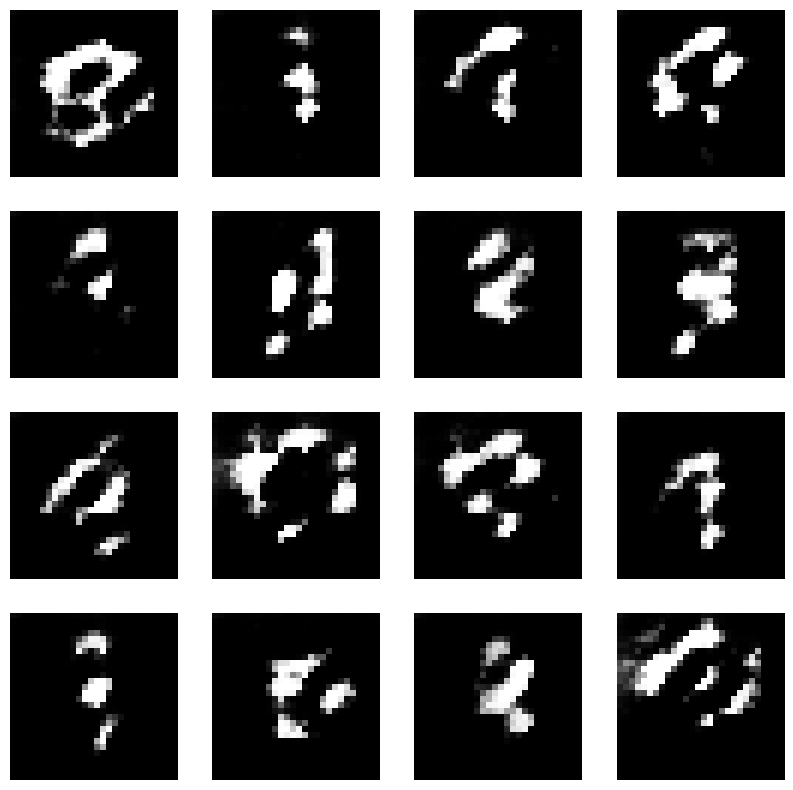

Epoch:  20


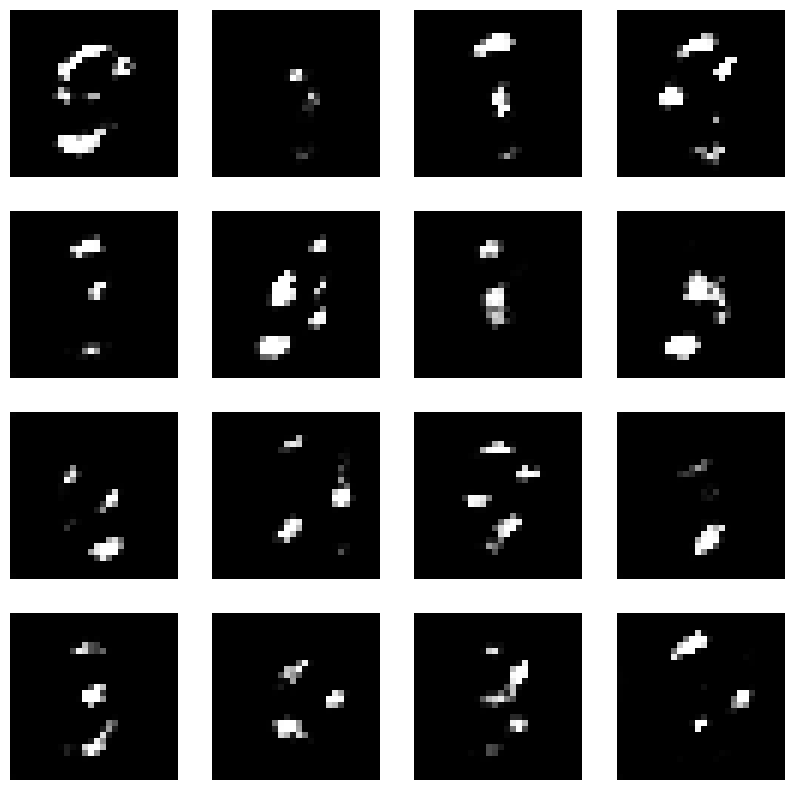

Epoch:  21


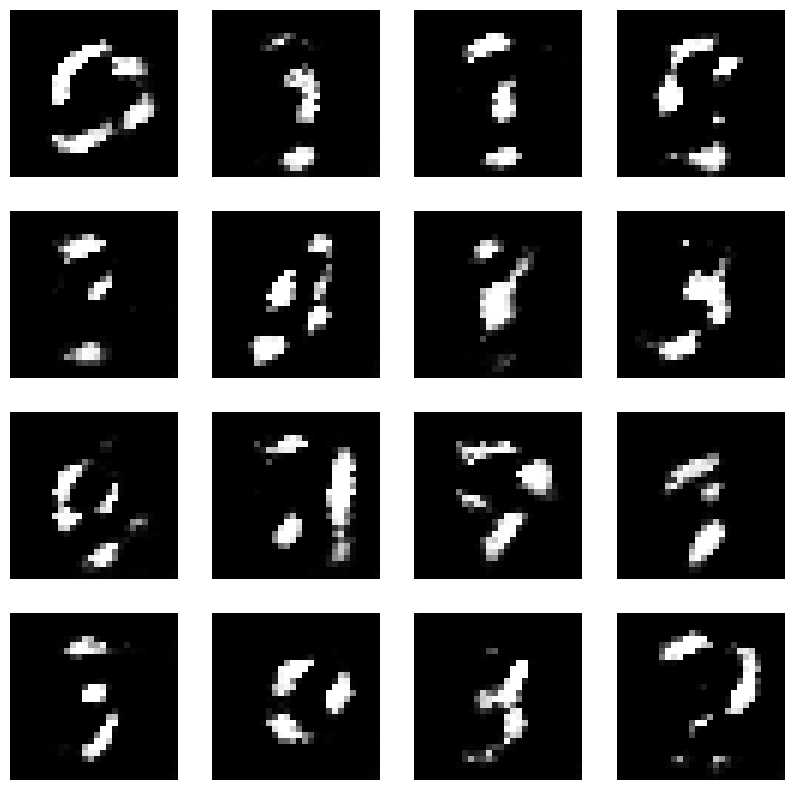

Epoch:  22


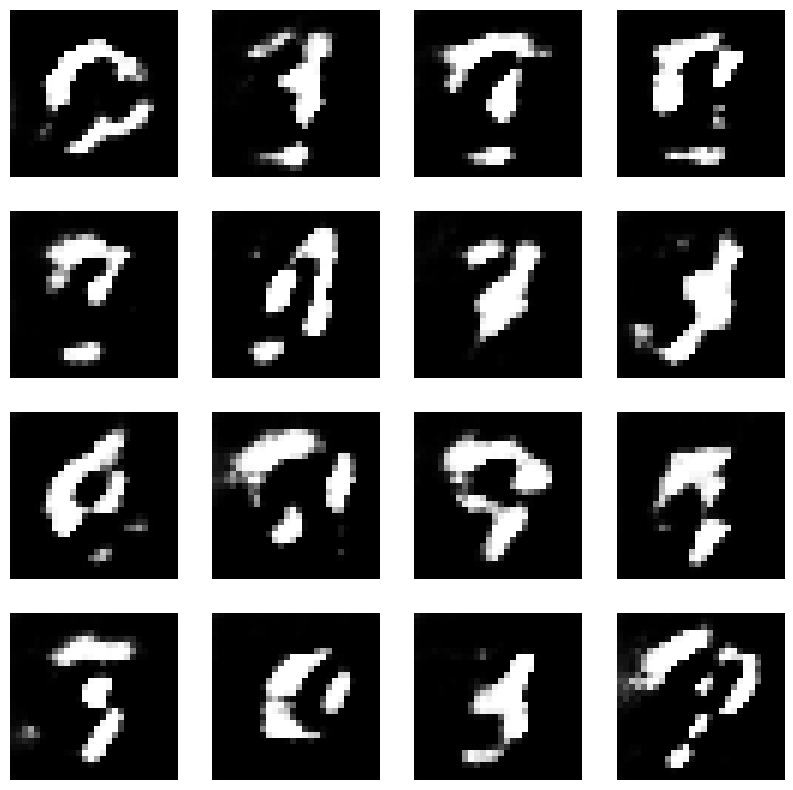

Epoch:  23


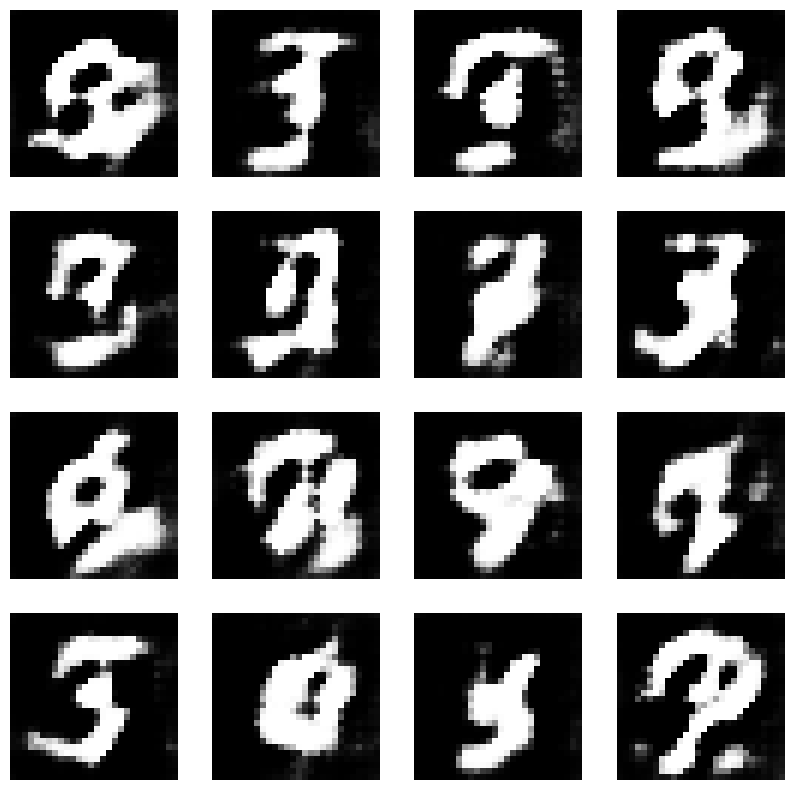

Epoch:  24


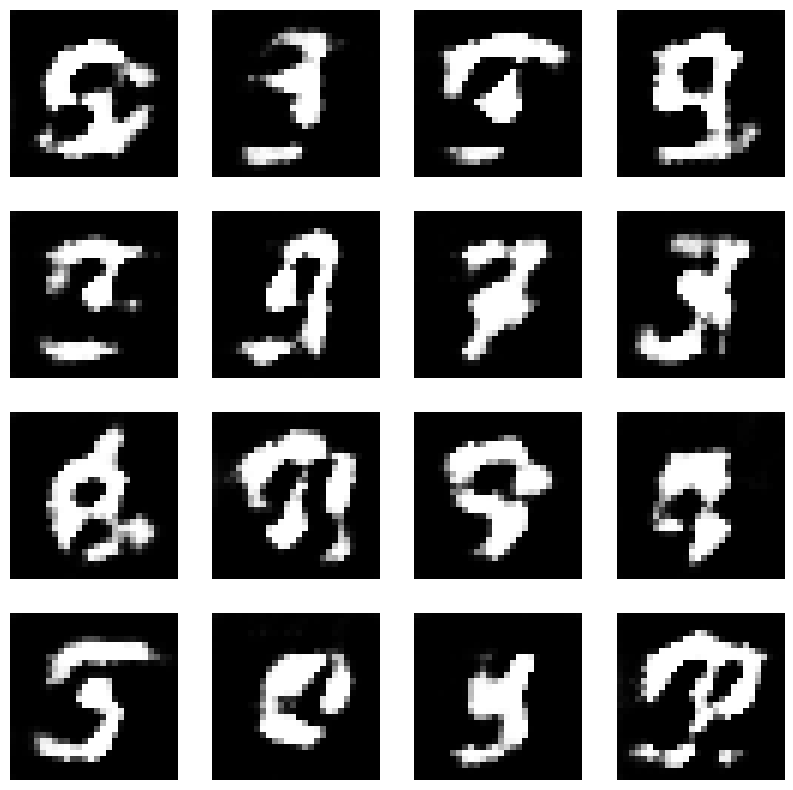

Epoch:  25


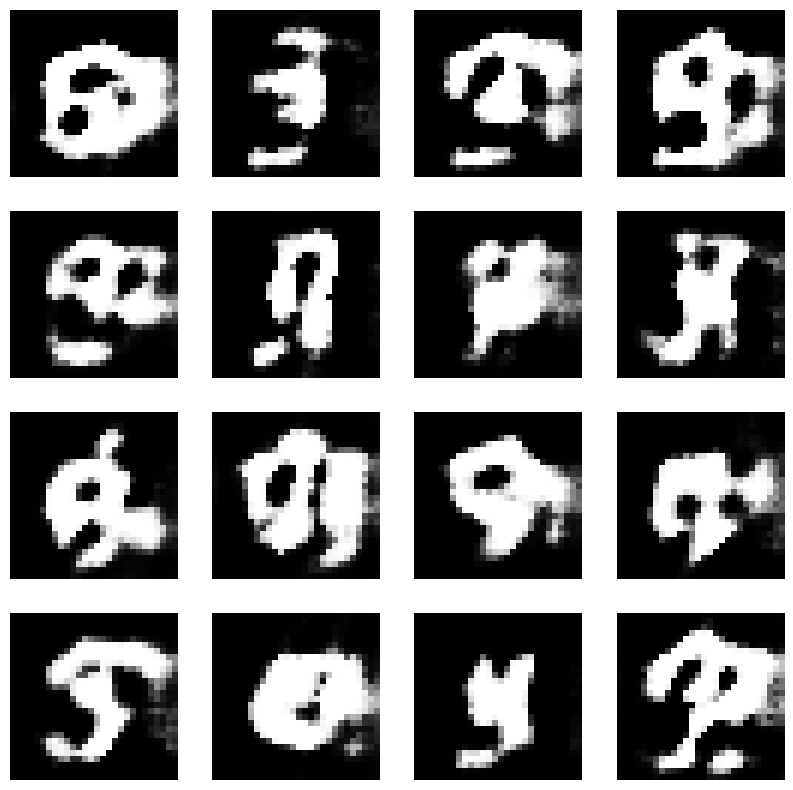

Epoch:  26


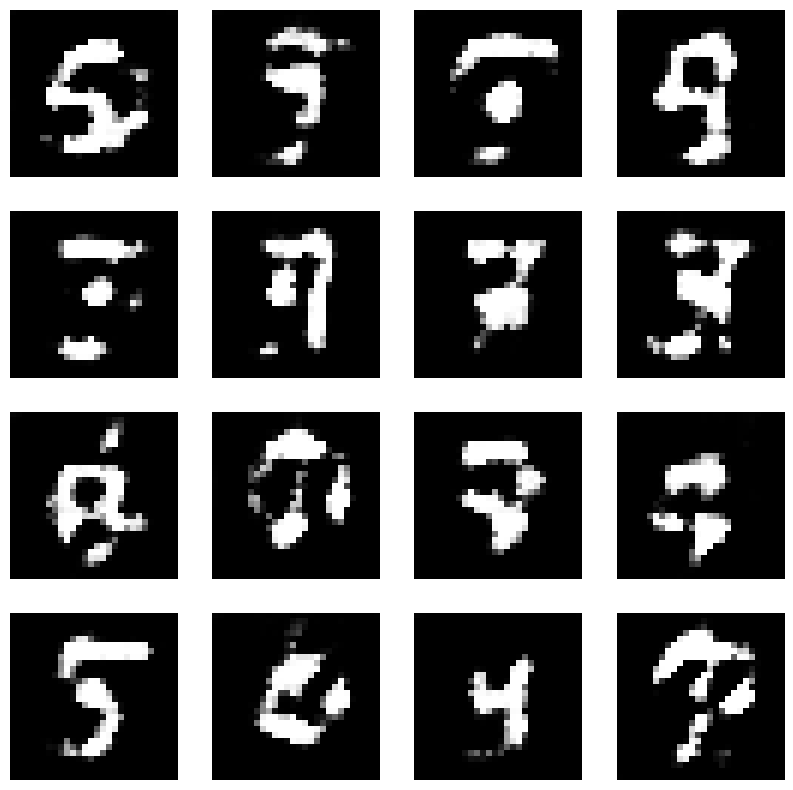

Epoch:  27


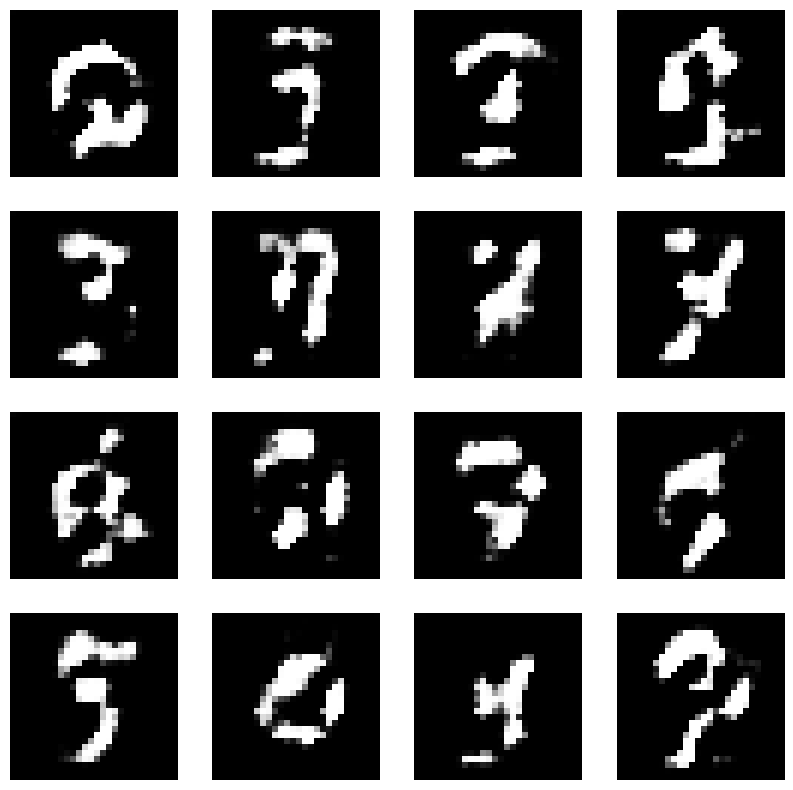

Epoch:  28


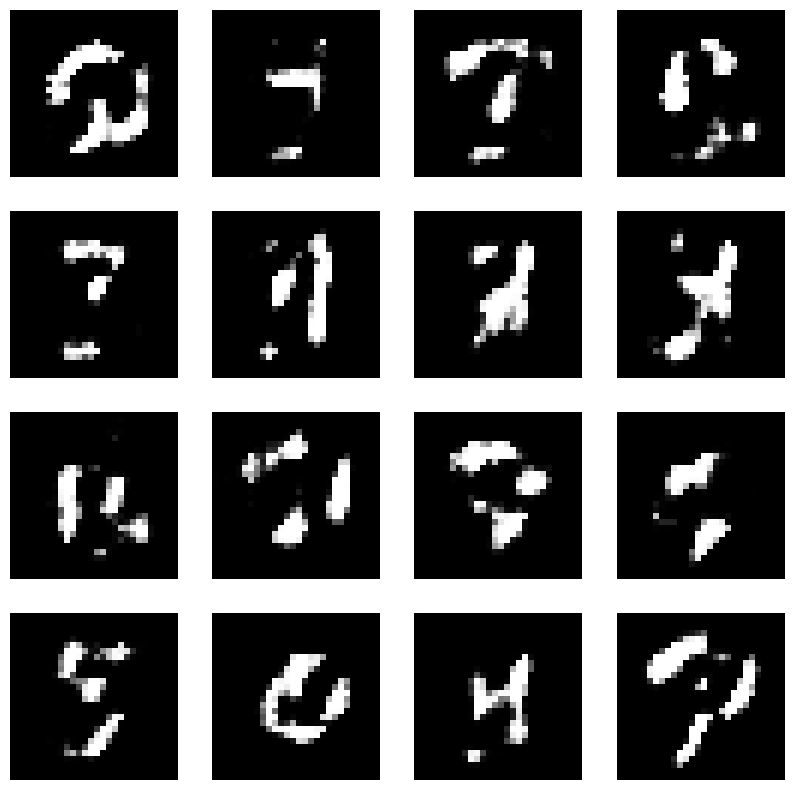

Epoch:  29


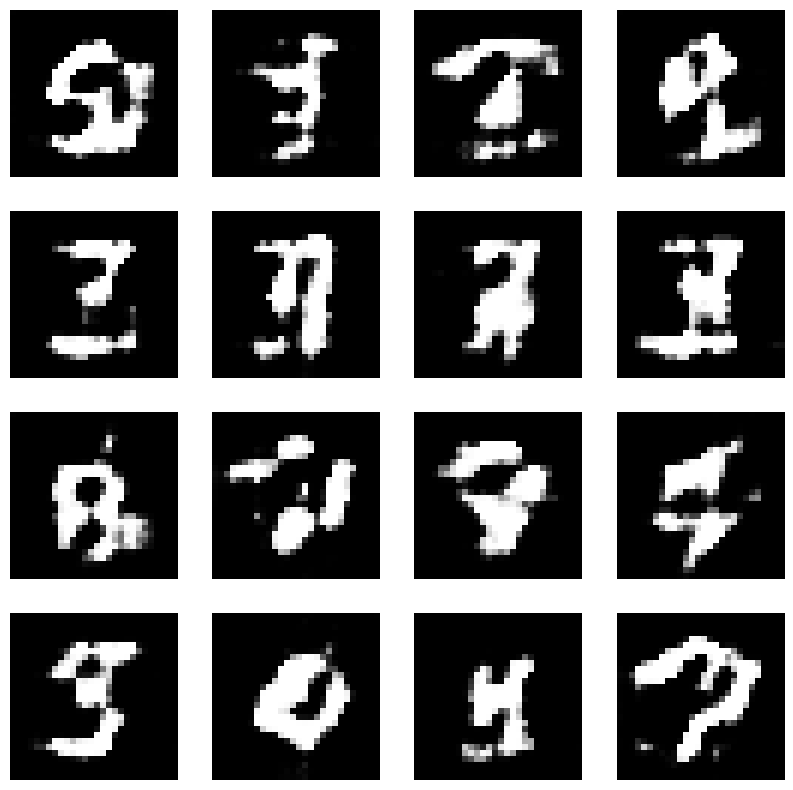

Epoch:  30


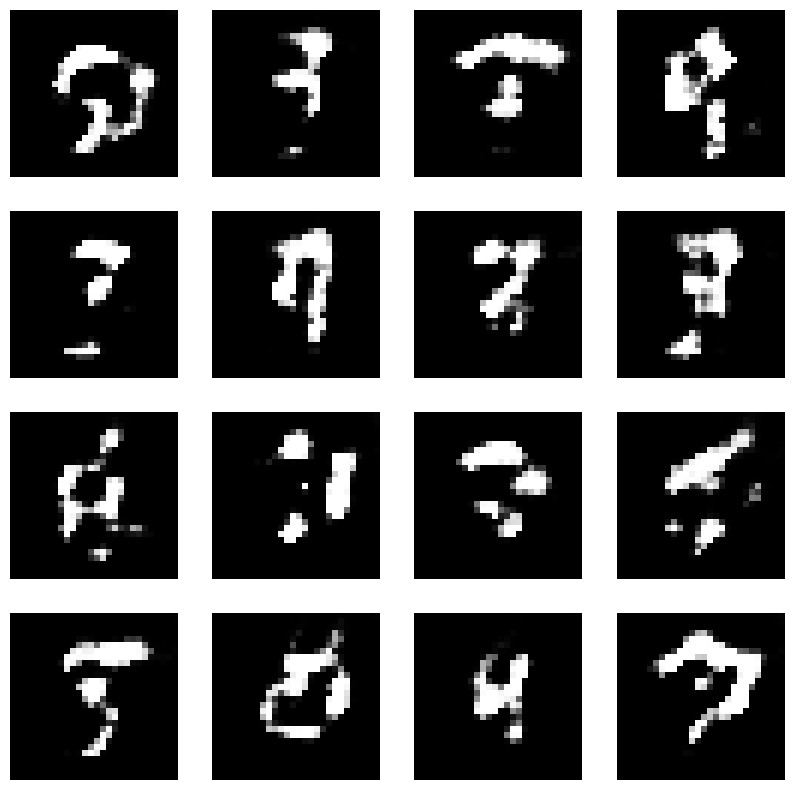

Epoch:  31


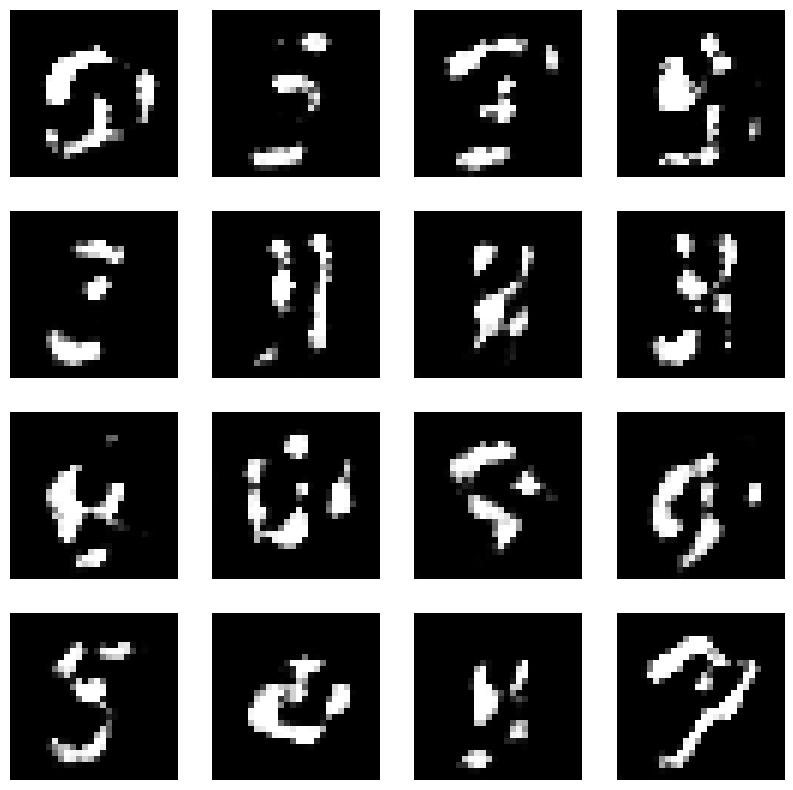

Epoch:  32


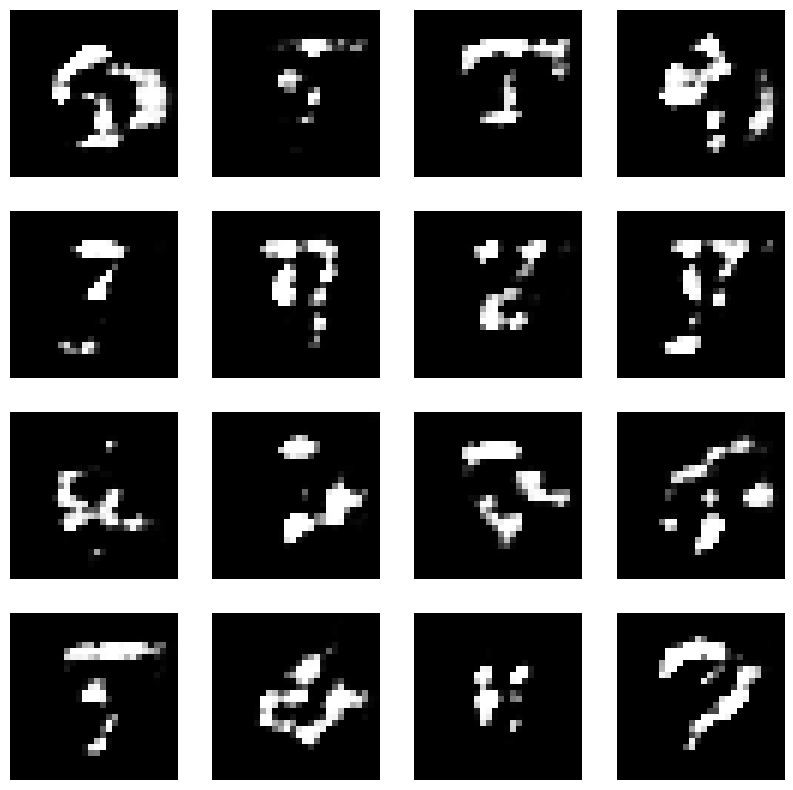

Epoch:  33


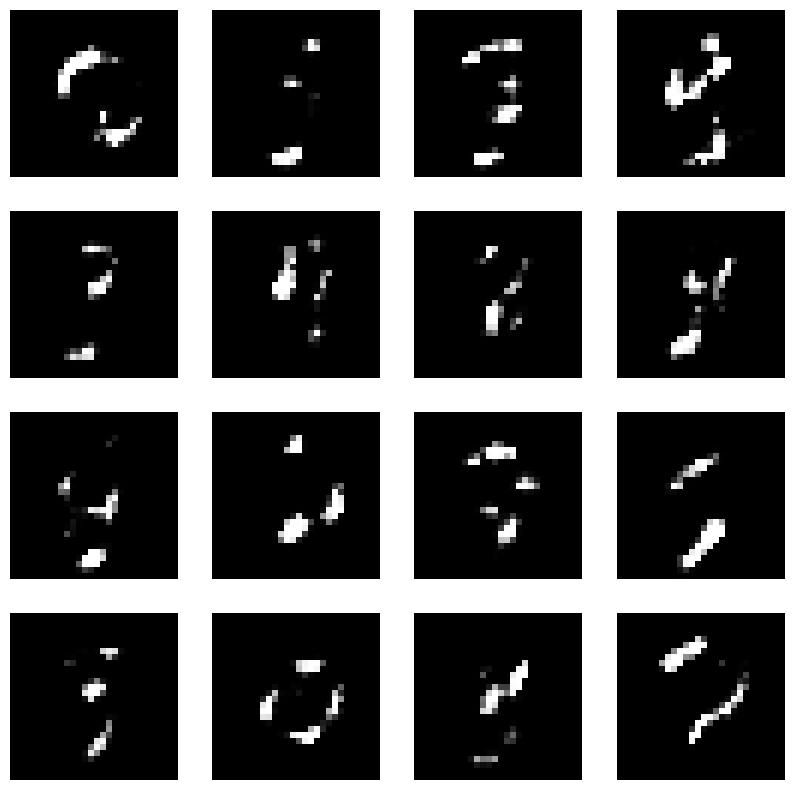

Epoch:  34


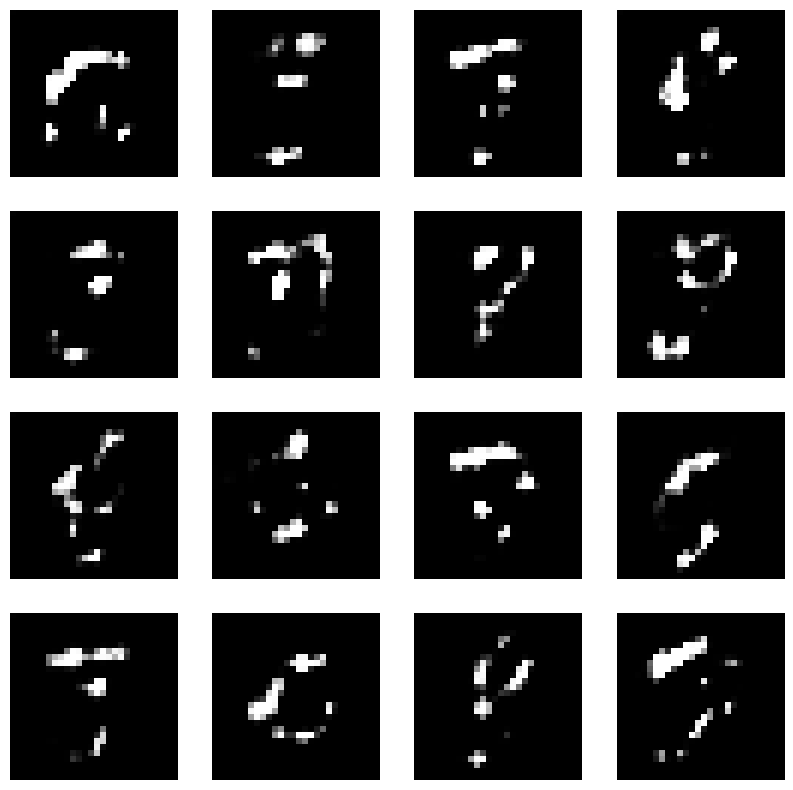

Epoch:  35


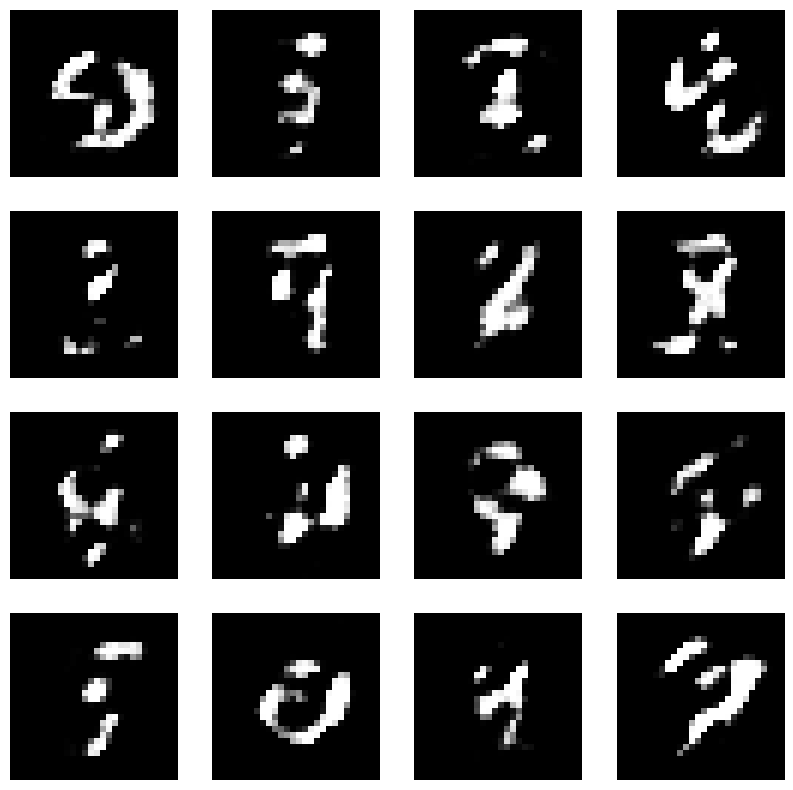

Epoch:  36


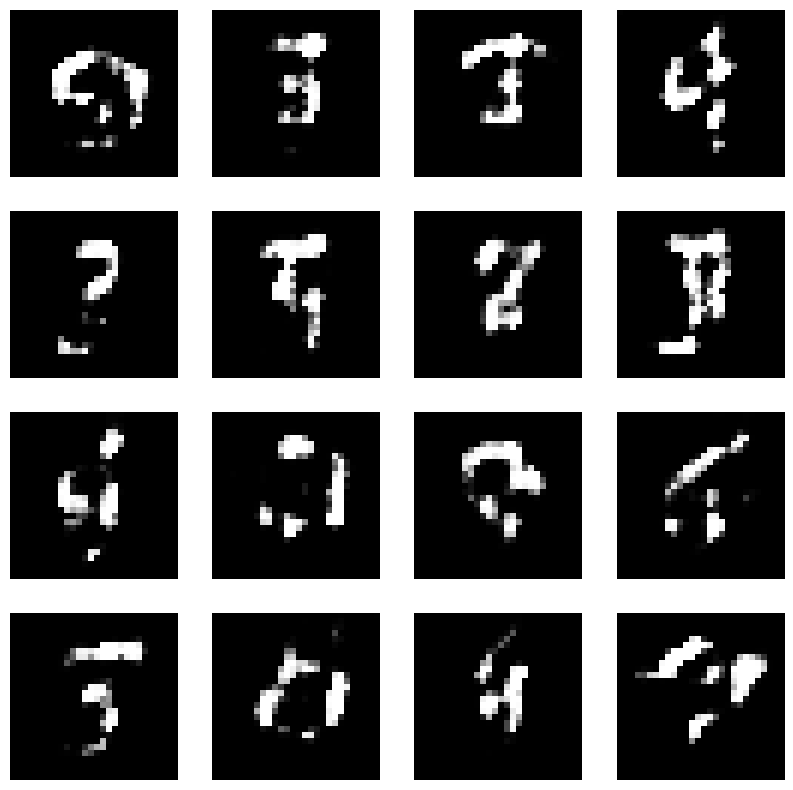

Epoch:  37


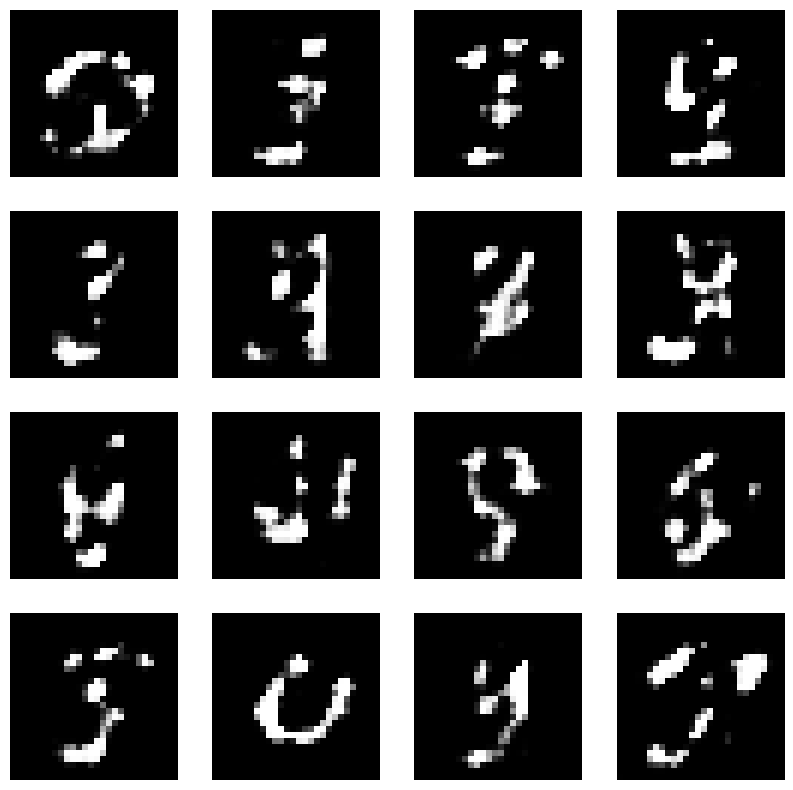

Epoch:  38


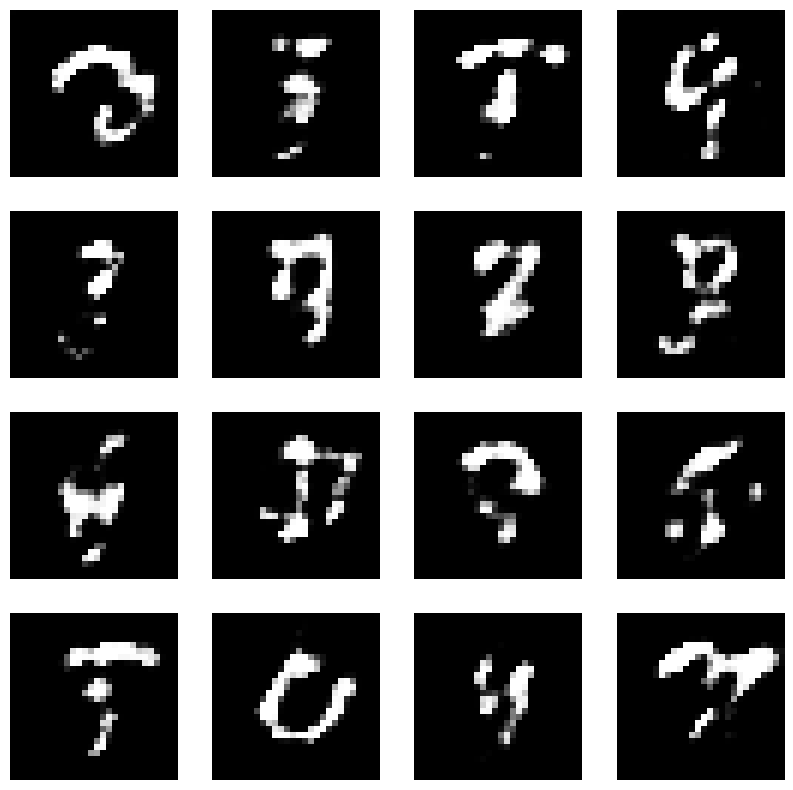

Epoch:  39


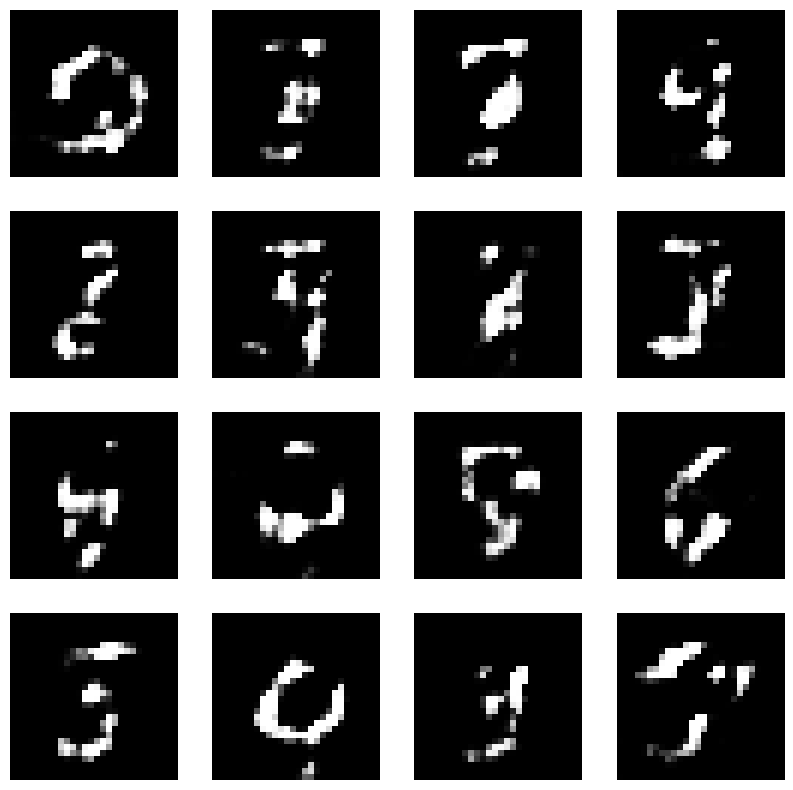

Epoch:  40


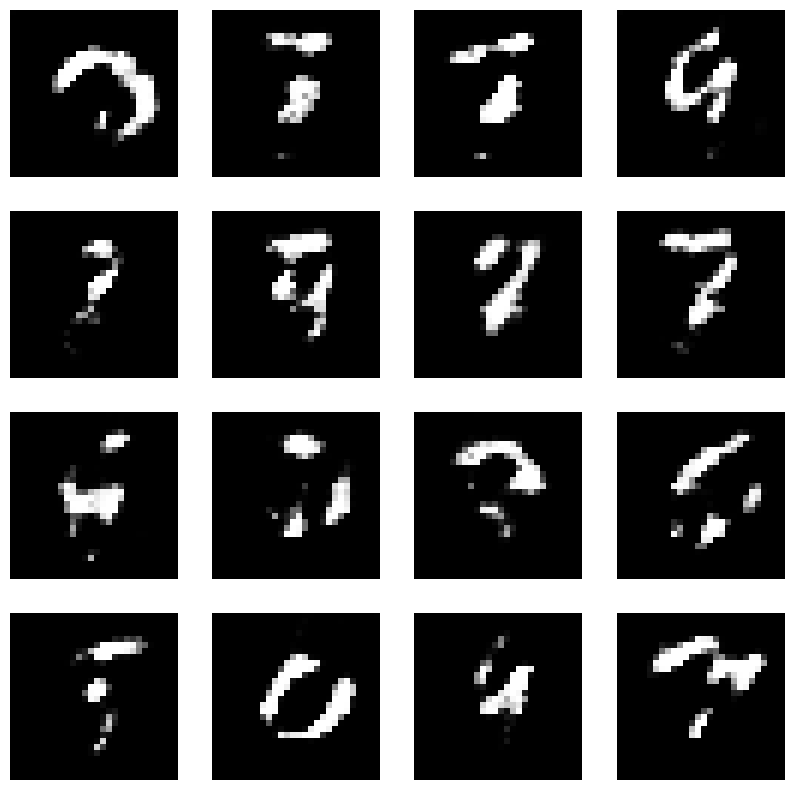

Epoch:  41


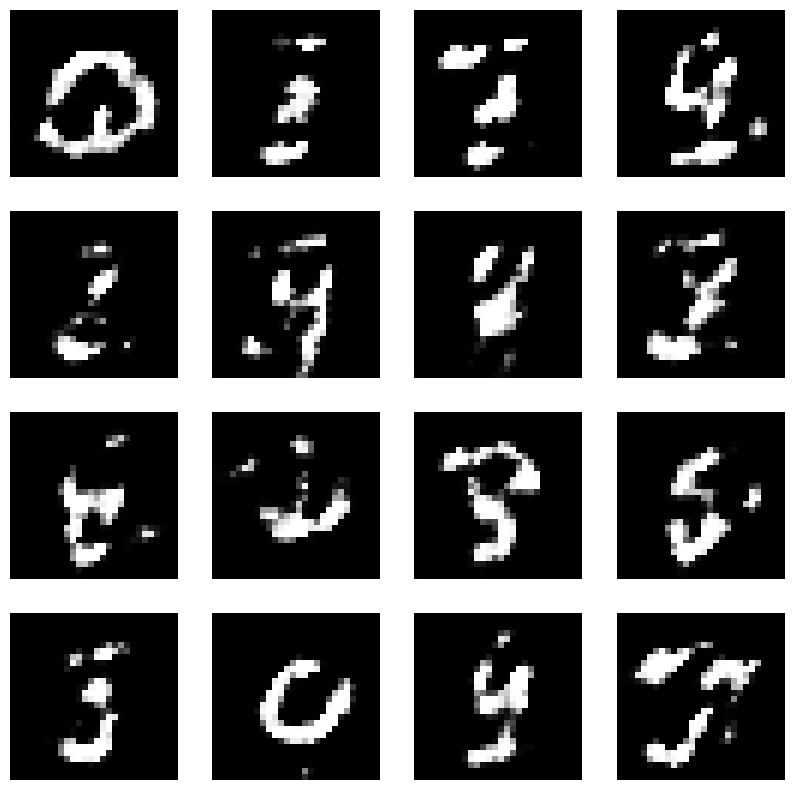

Epoch:  42


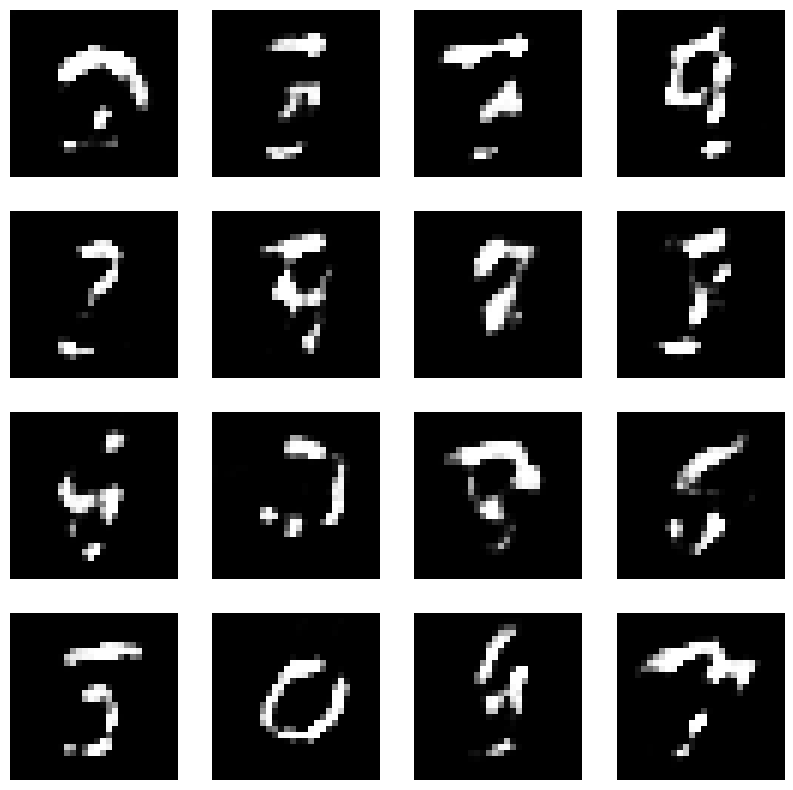

Epoch:  43


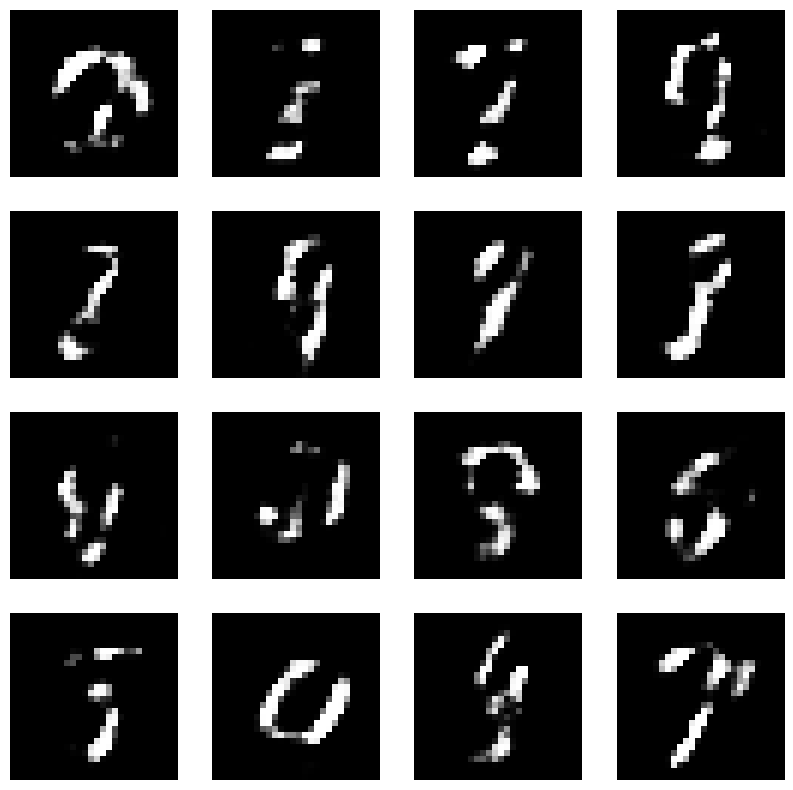

Epoch:  44


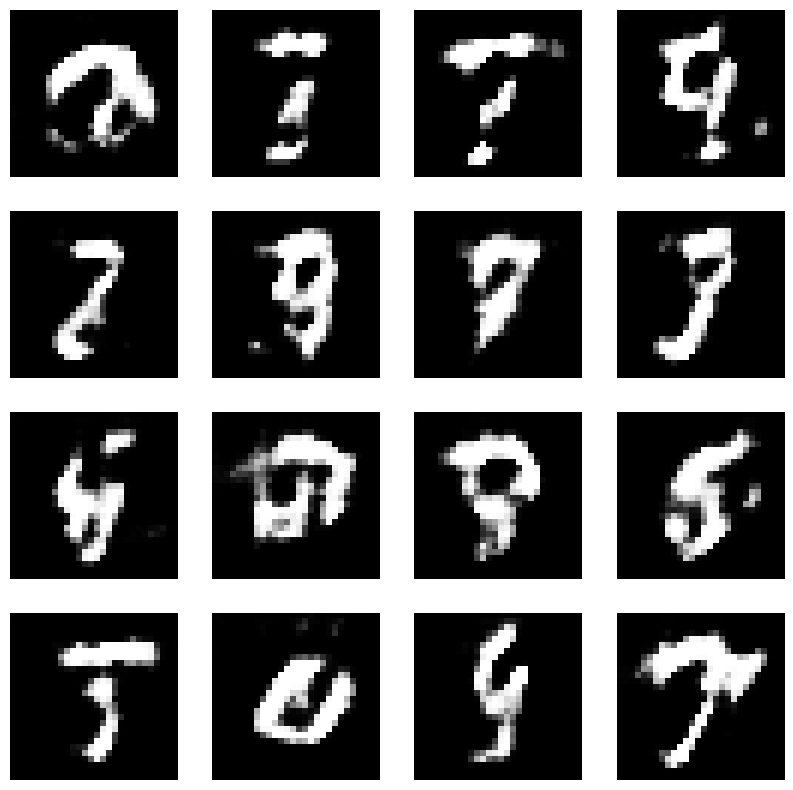

Epoch:  45


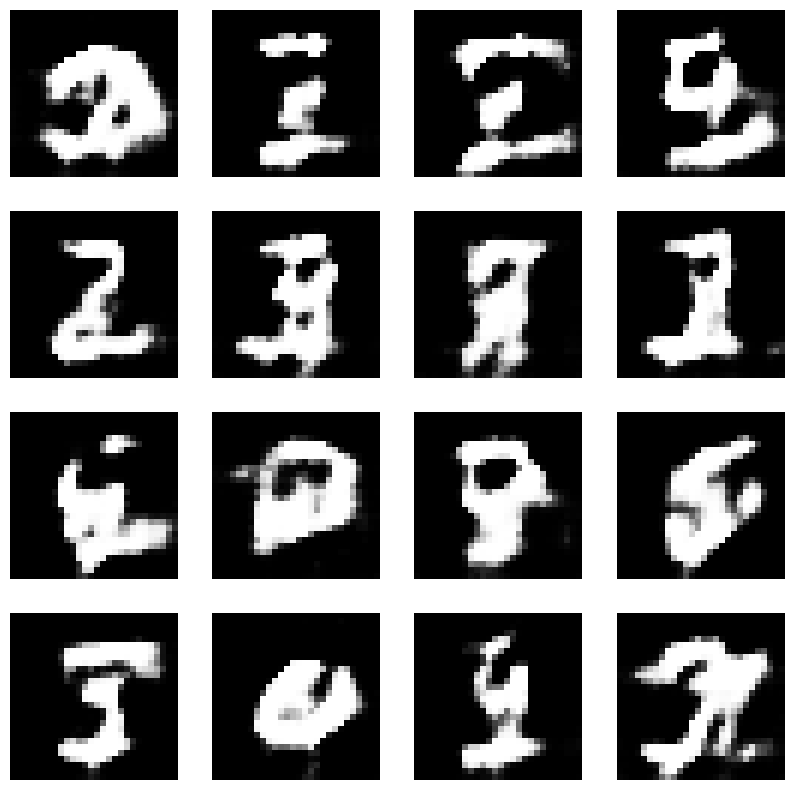

Epoch:  46


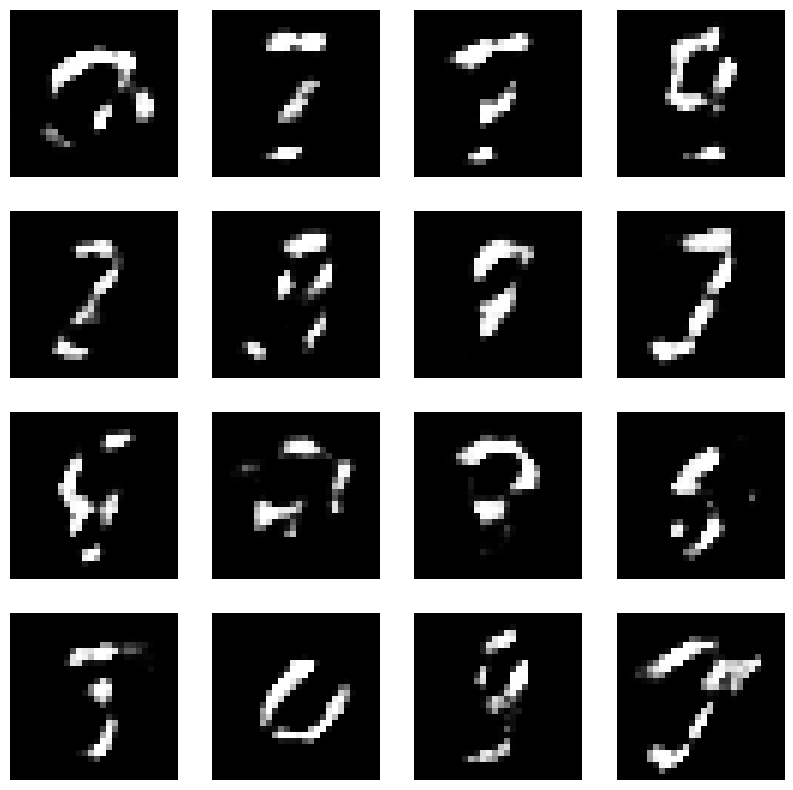

Epoch:  47


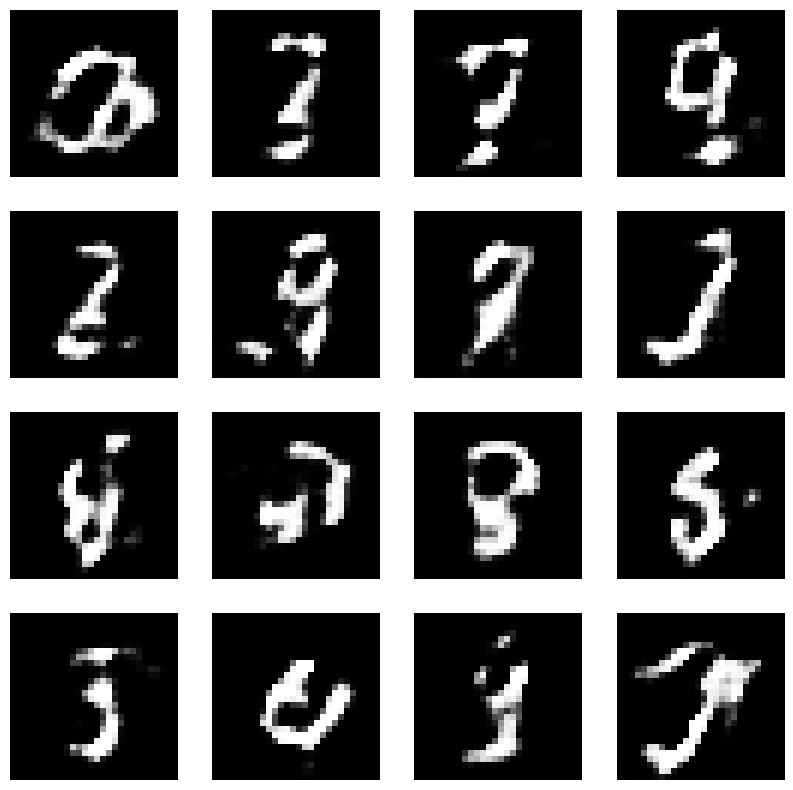

Epoch:  48


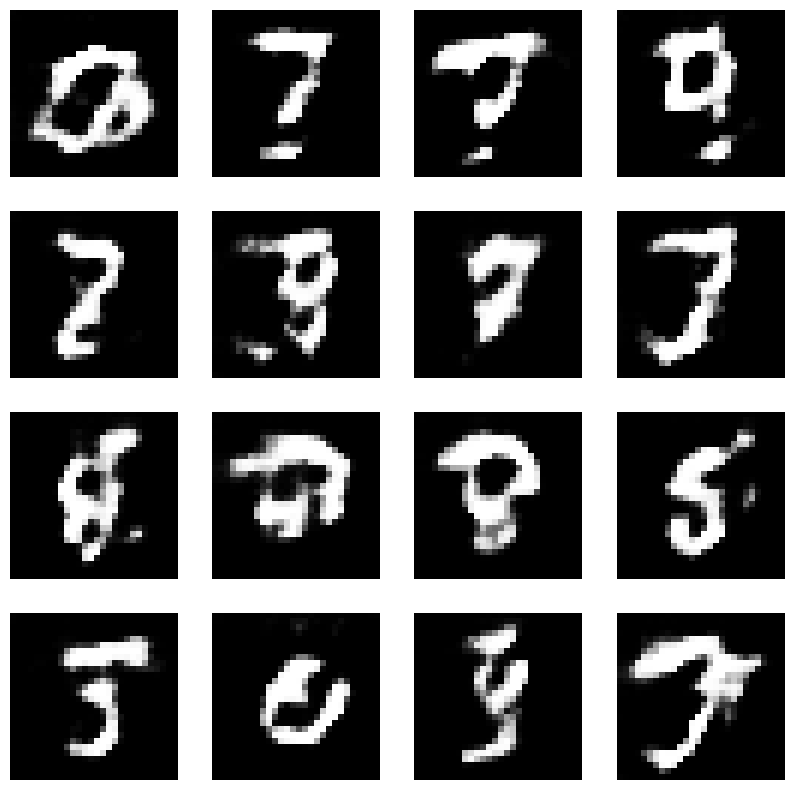

Epoch:  49


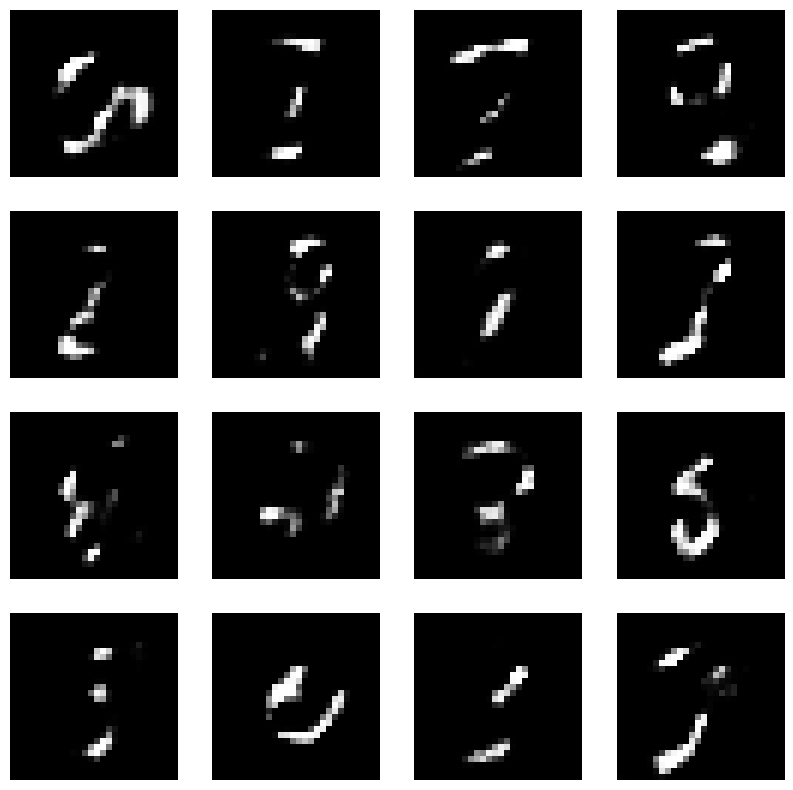

Epoch:  50


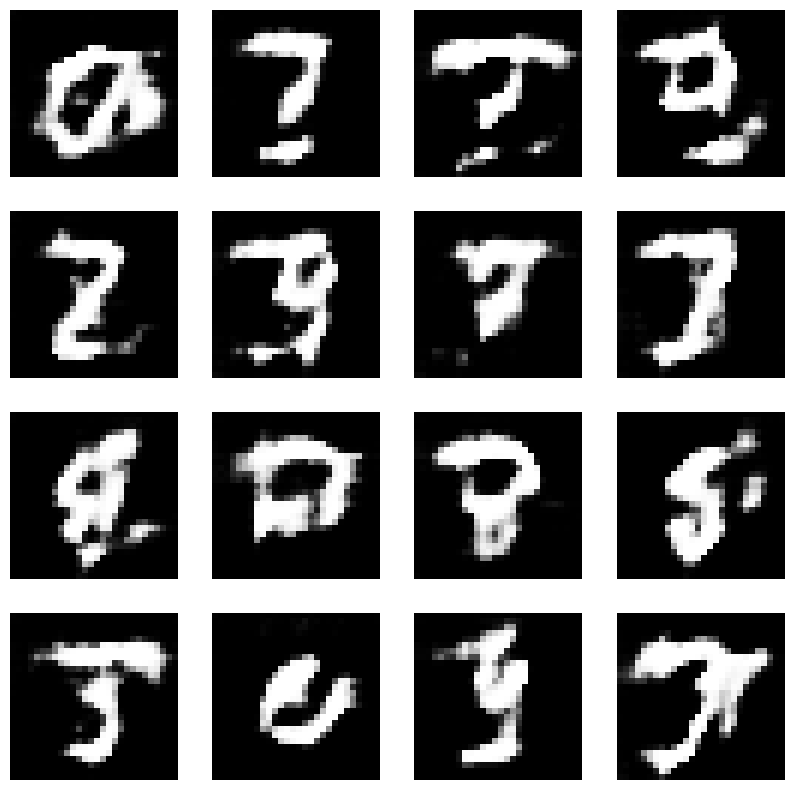

Epoch:  51


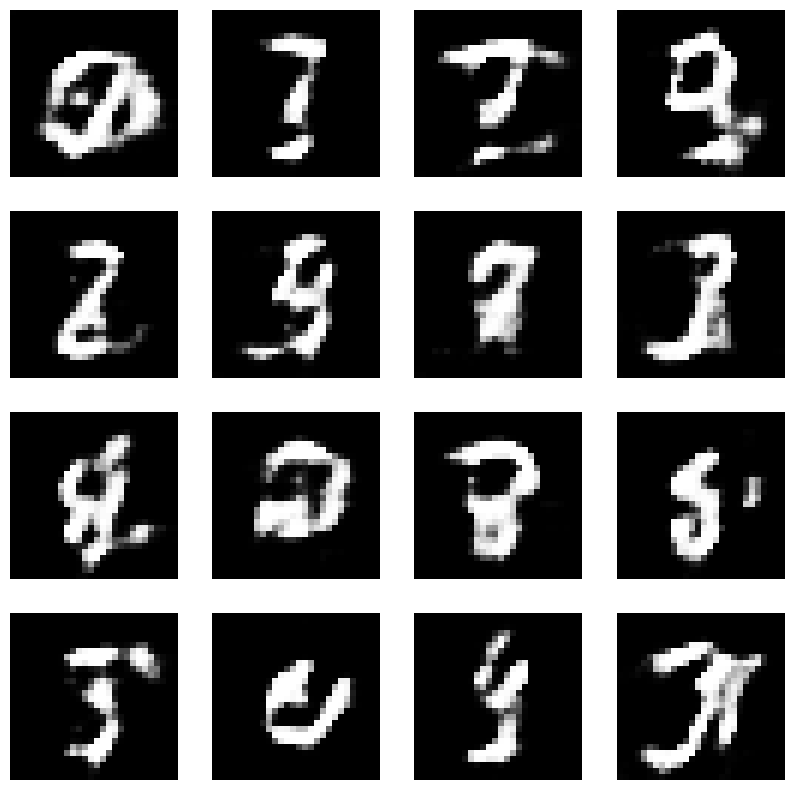

Epoch:  52


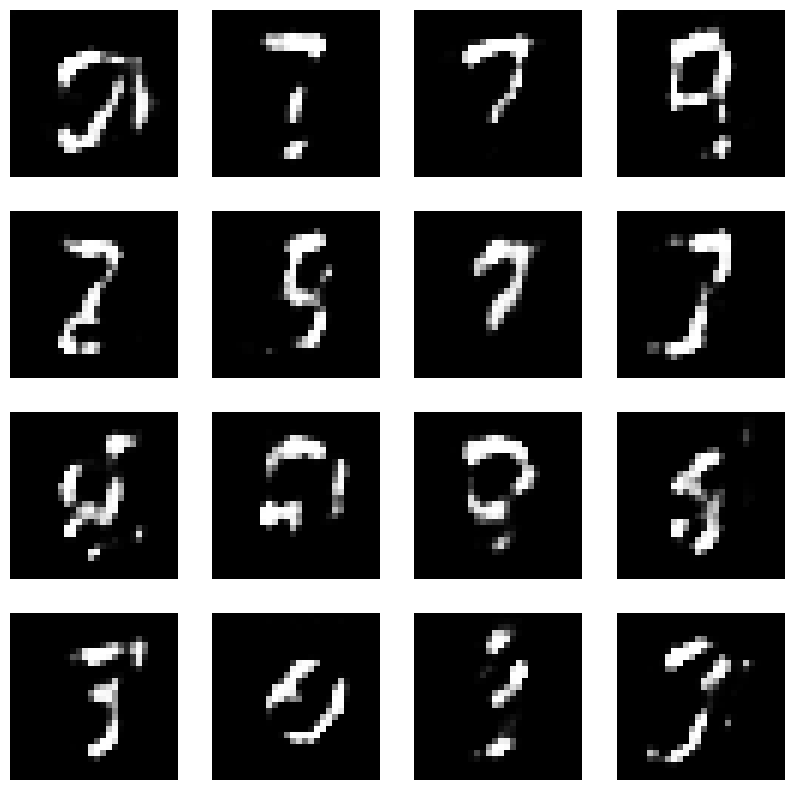

Epoch:  53


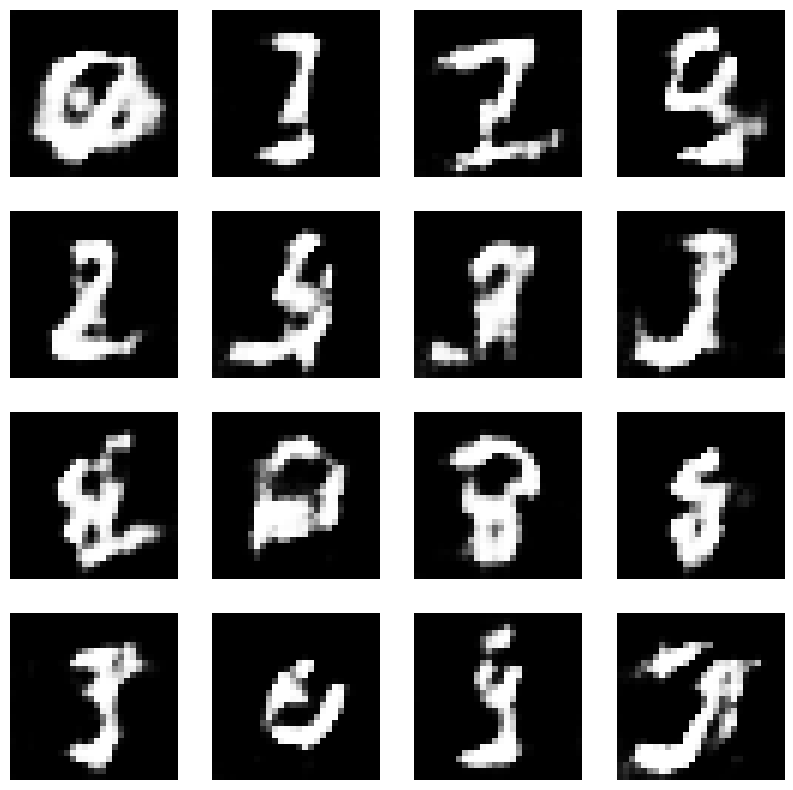

Epoch:  54


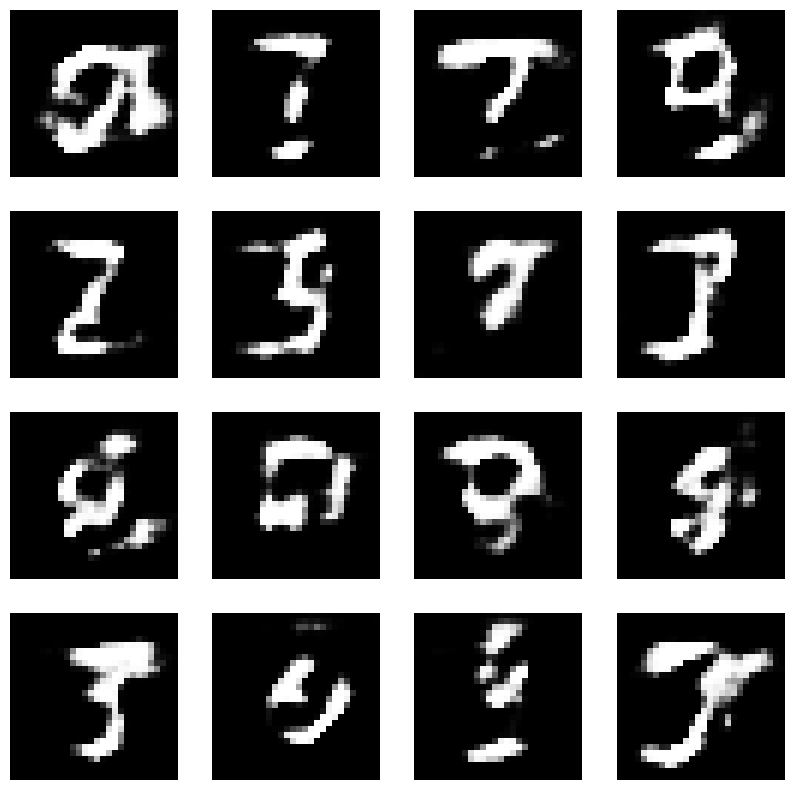

Epoch:  55


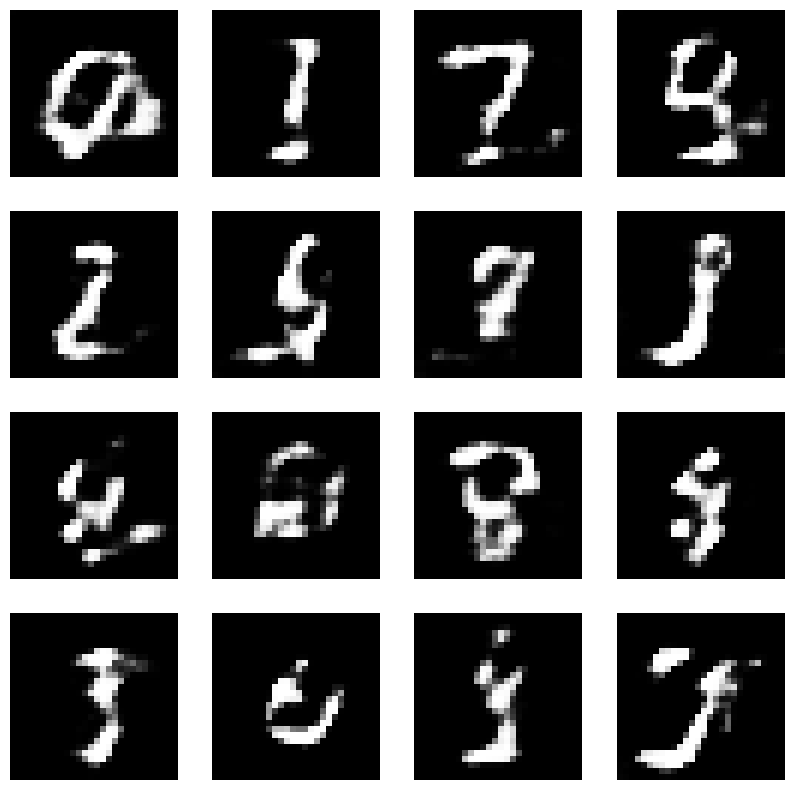

Epoch:  56


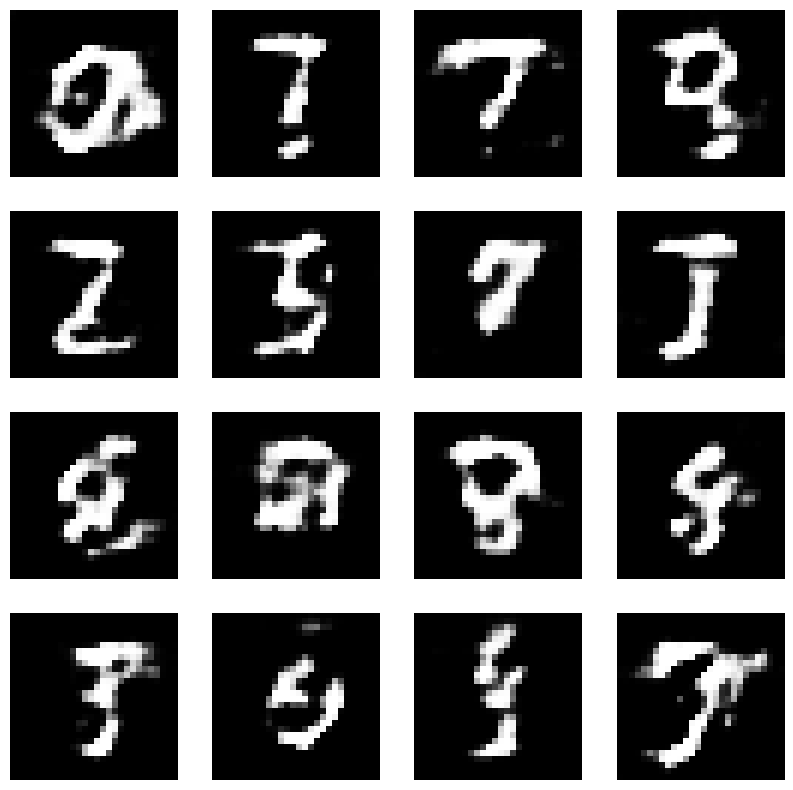

Epoch:  57


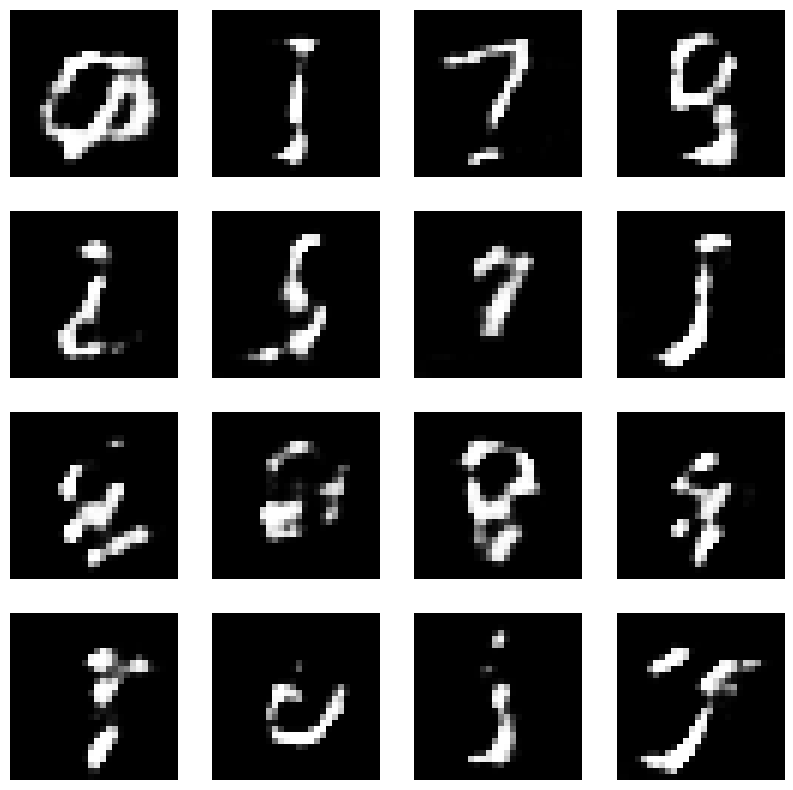

Epoch:  58


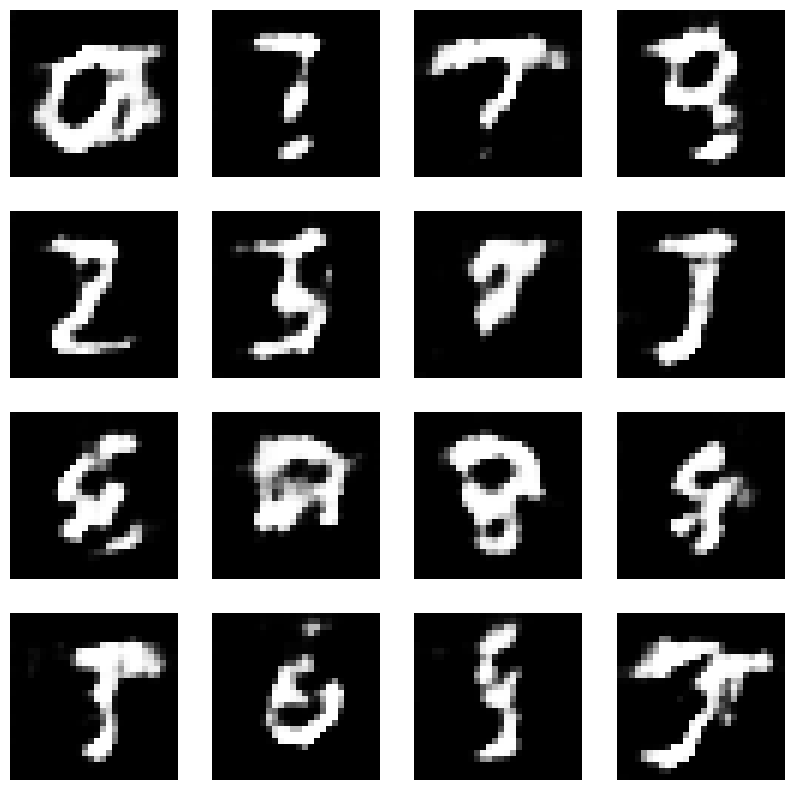

Epoch:  59


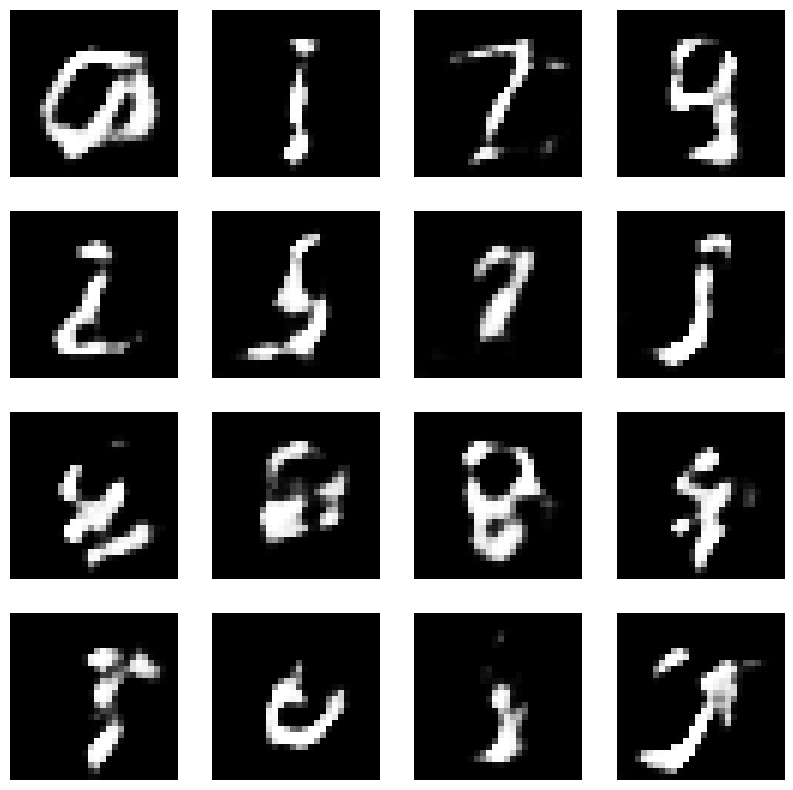

Epoch:  60


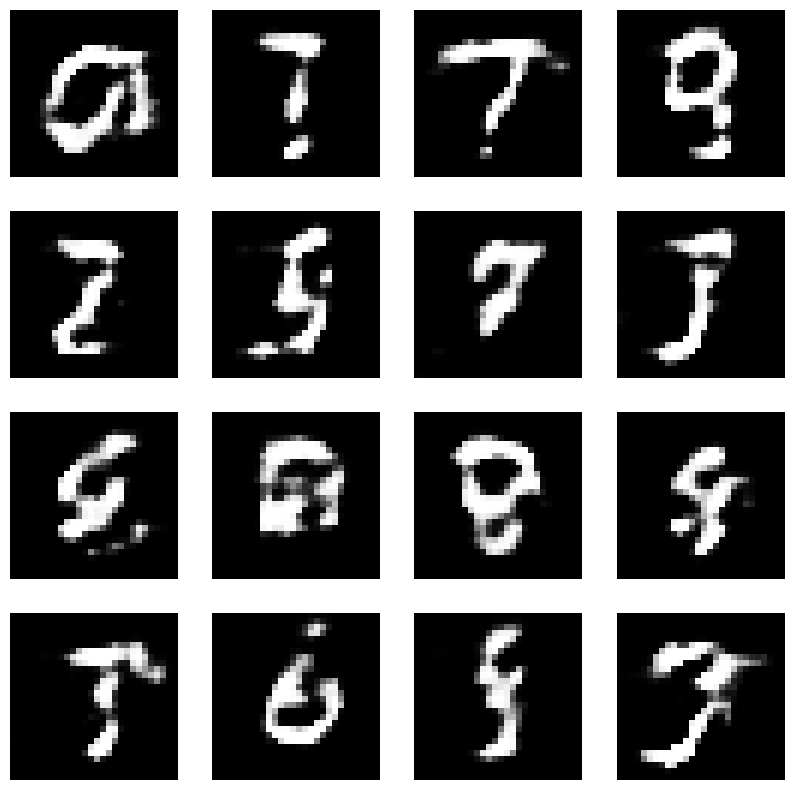

Epoch:  61


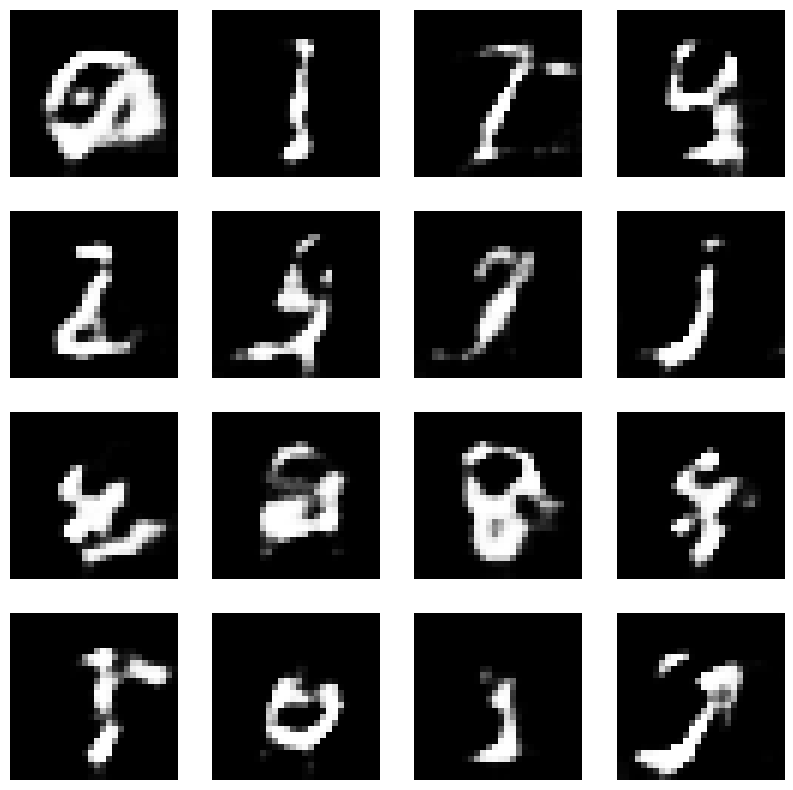

Epoch:  62


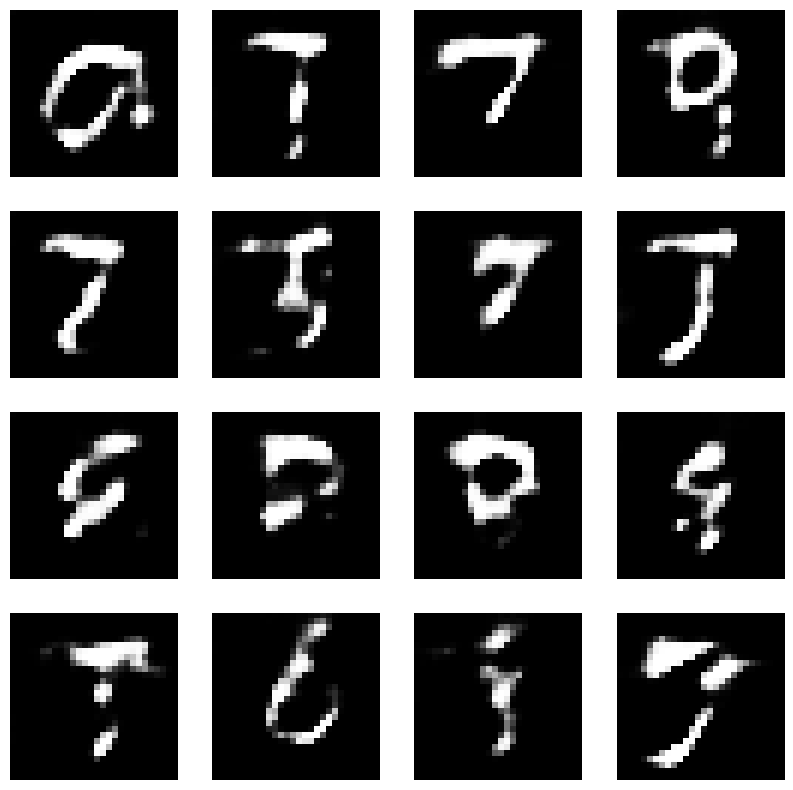

Epoch:  63


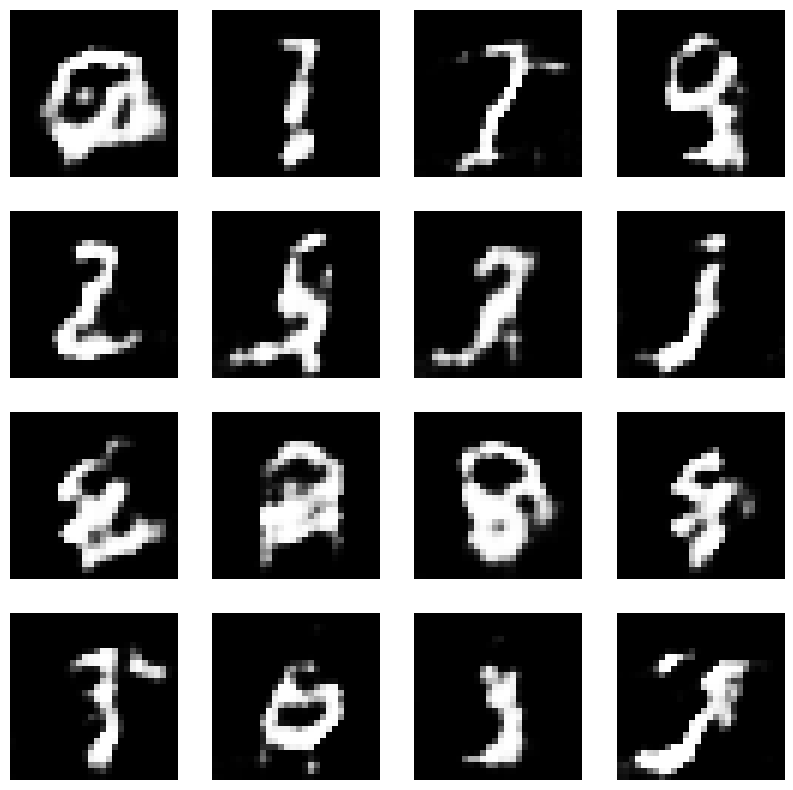

Epoch:  64


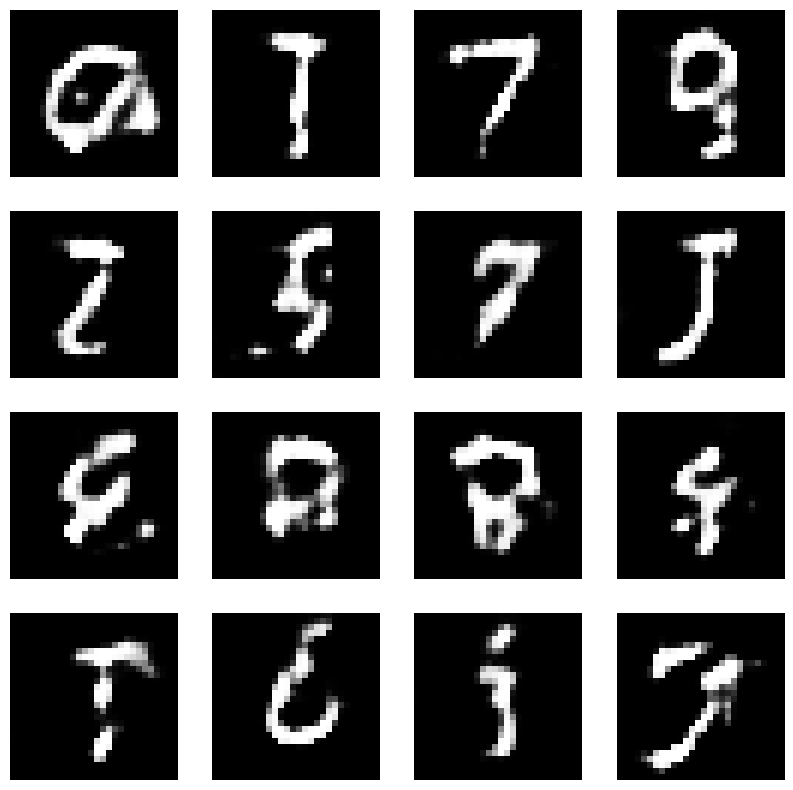

Epoch:  65


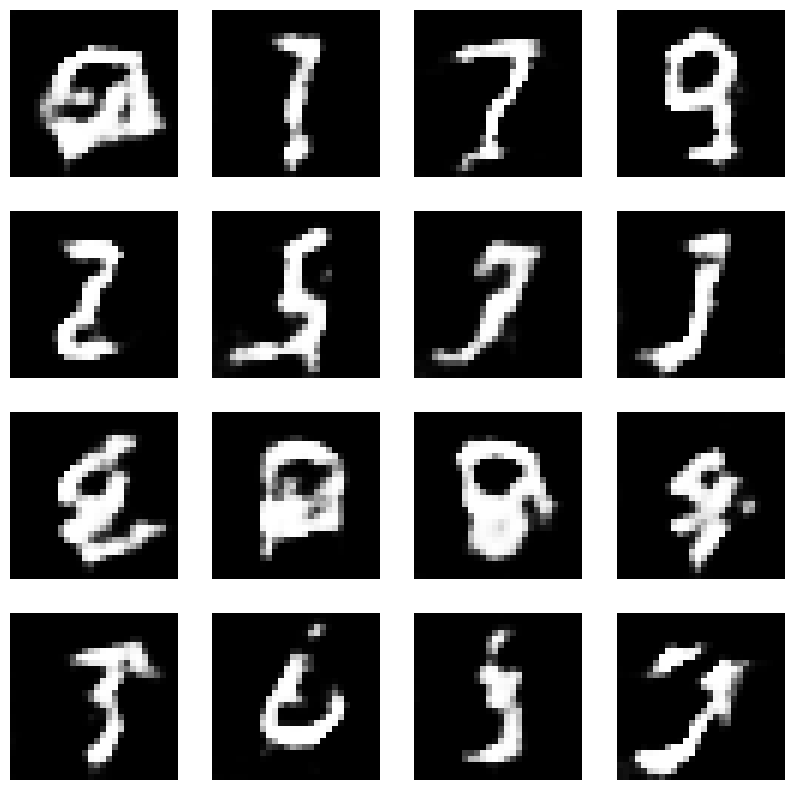

Epoch:  66


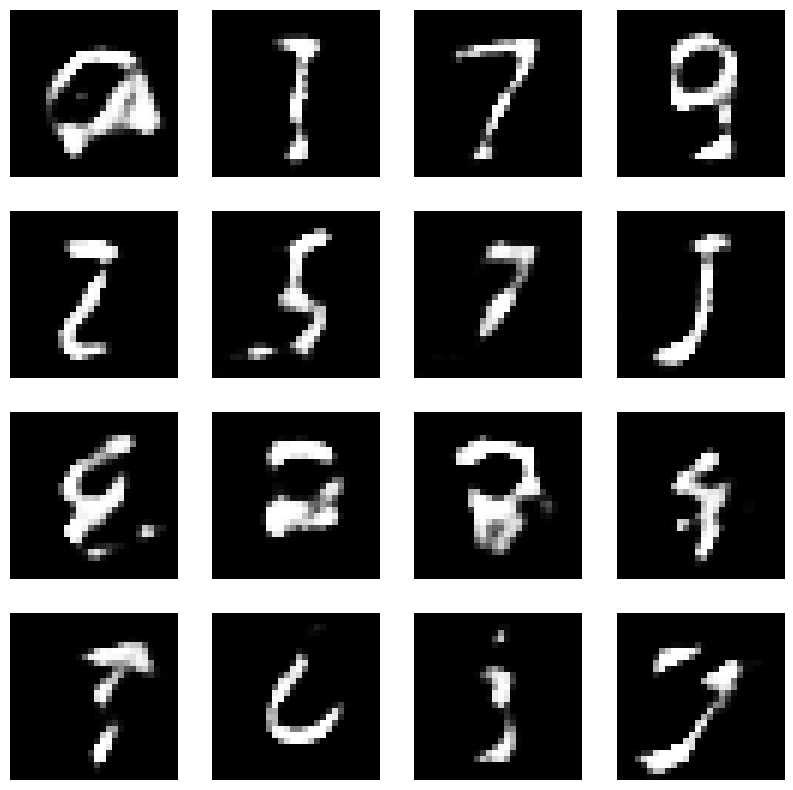

Epoch:  67


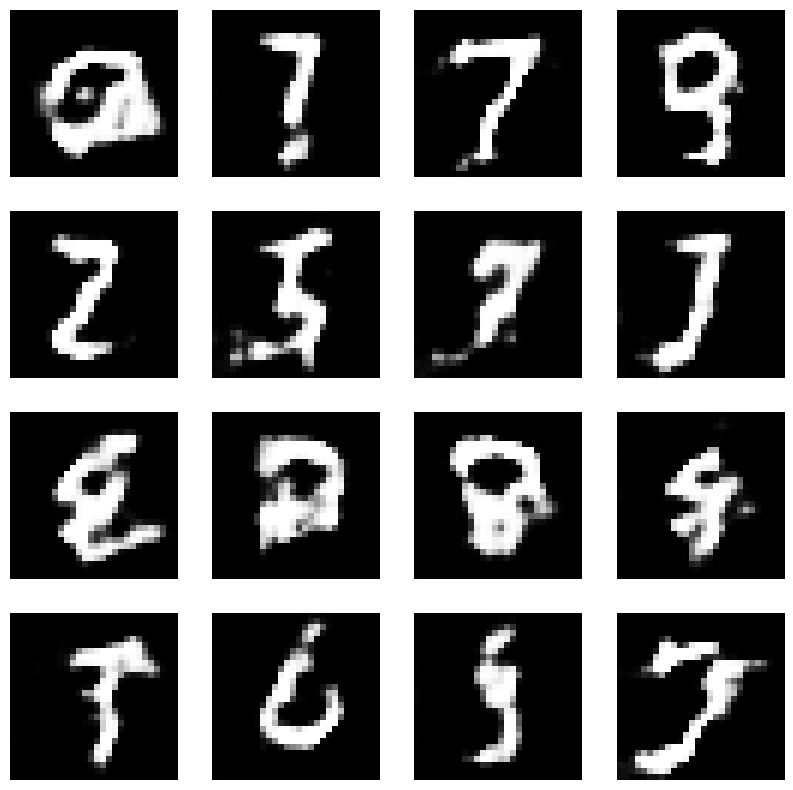

Epoch:  68


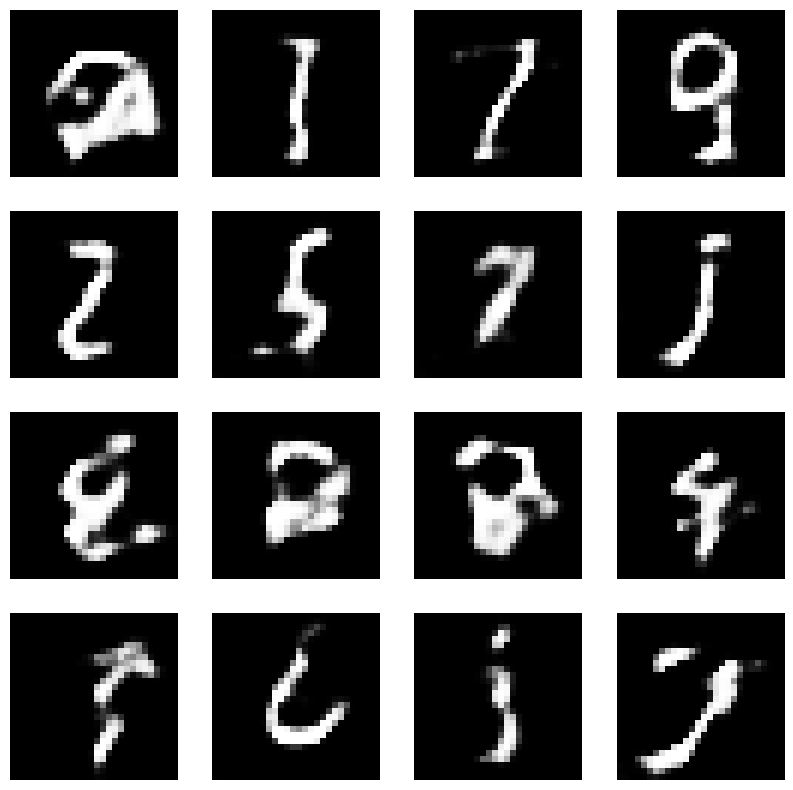

Epoch:  69


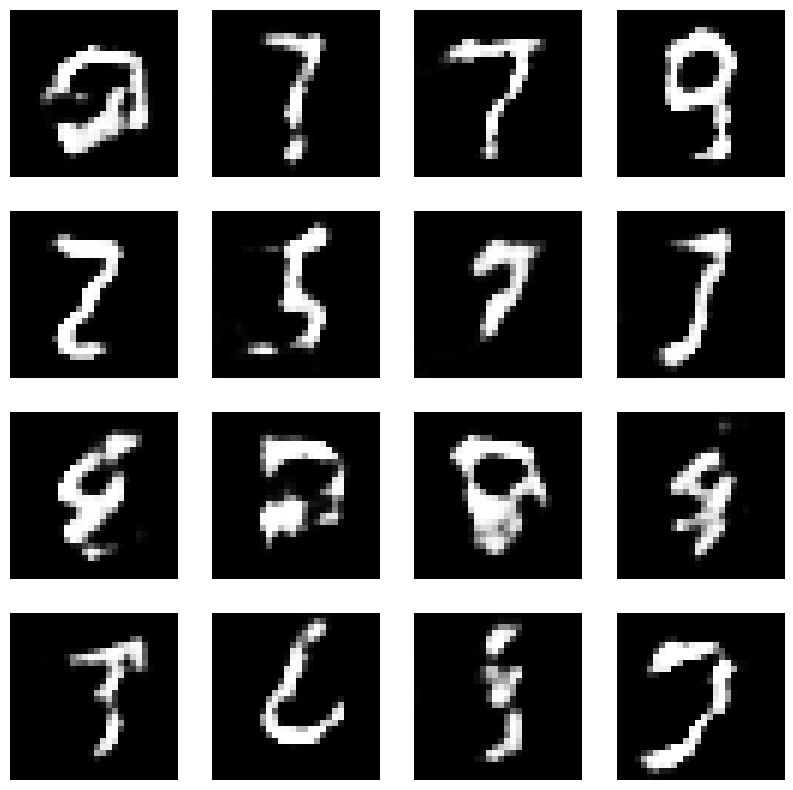

Epoch:  70


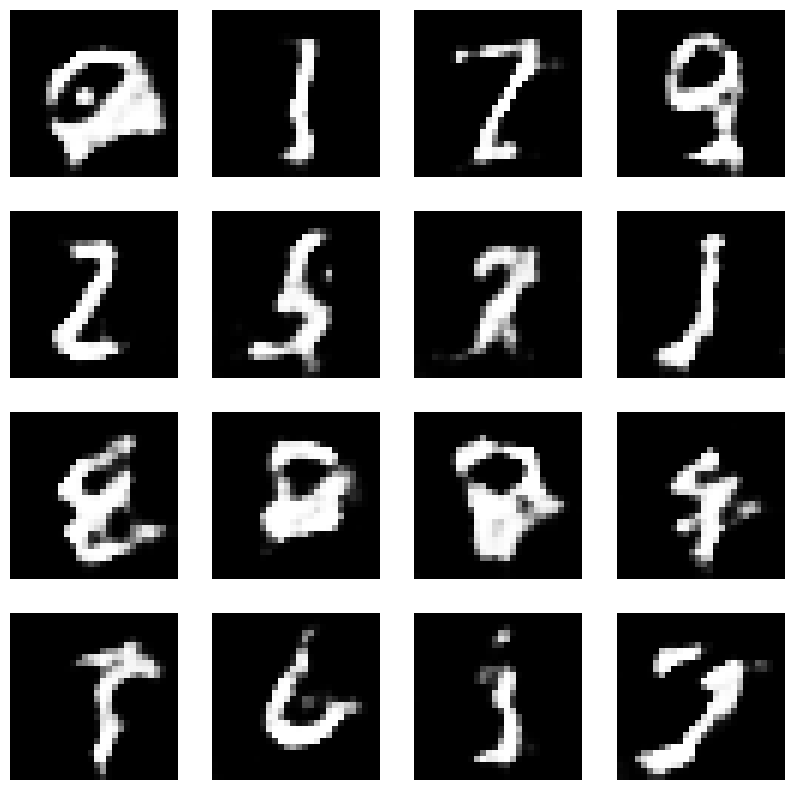

Epoch:  71


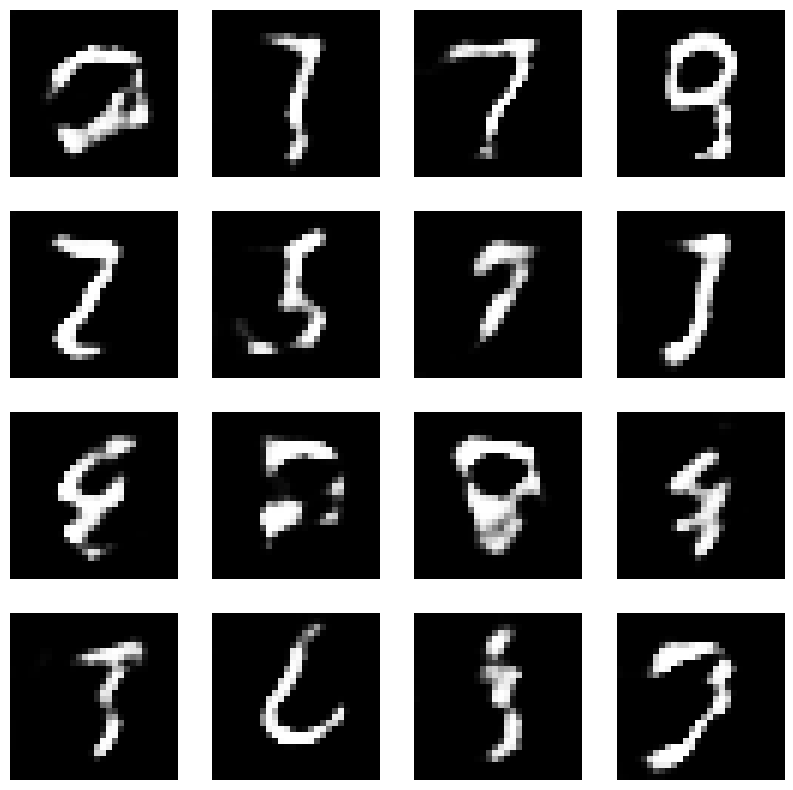

Epoch:  72


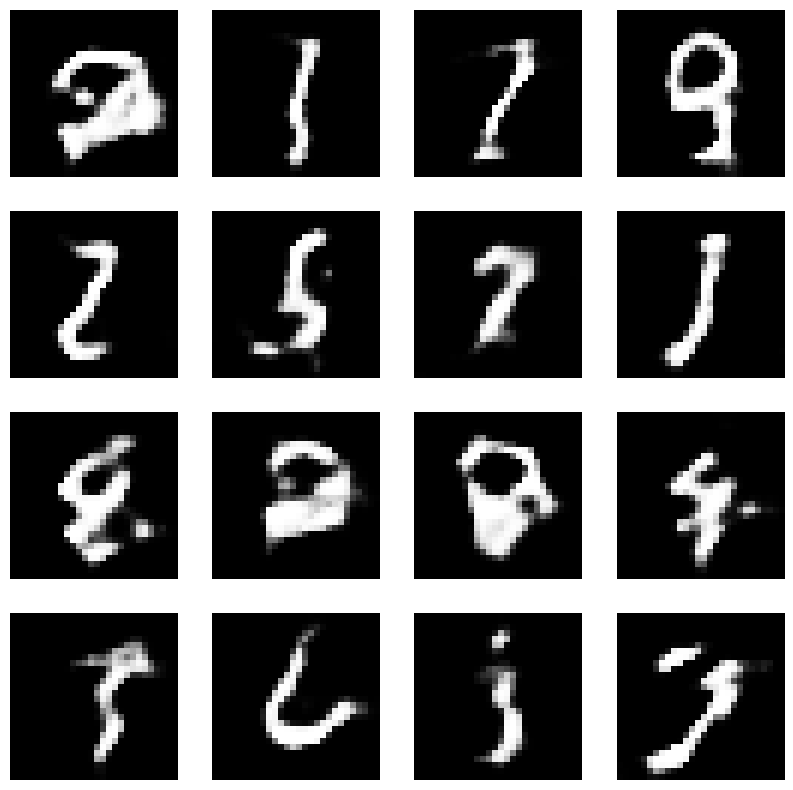

Epoch:  73


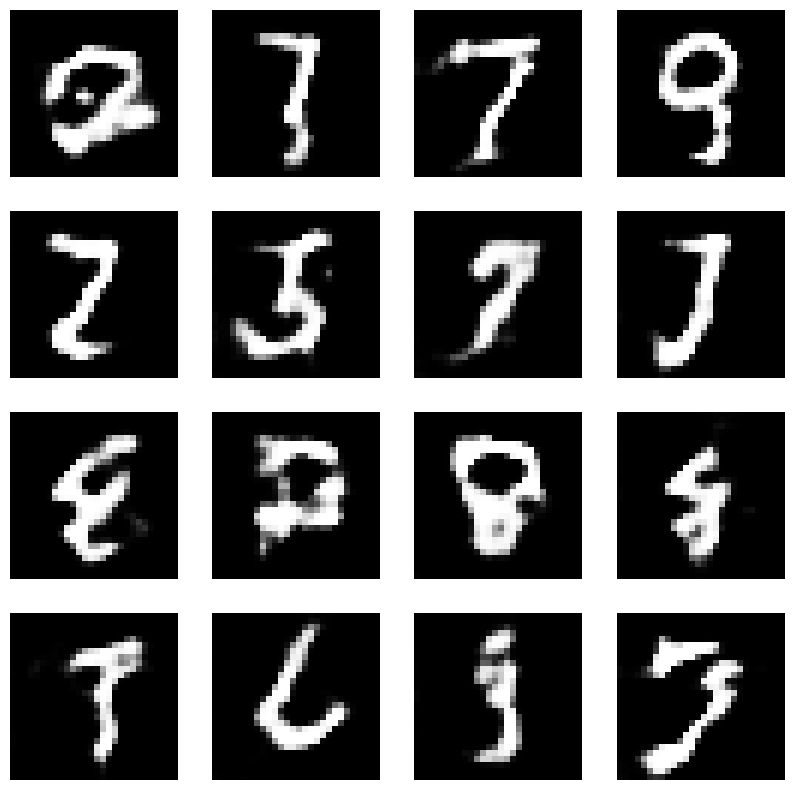

Epoch:  74


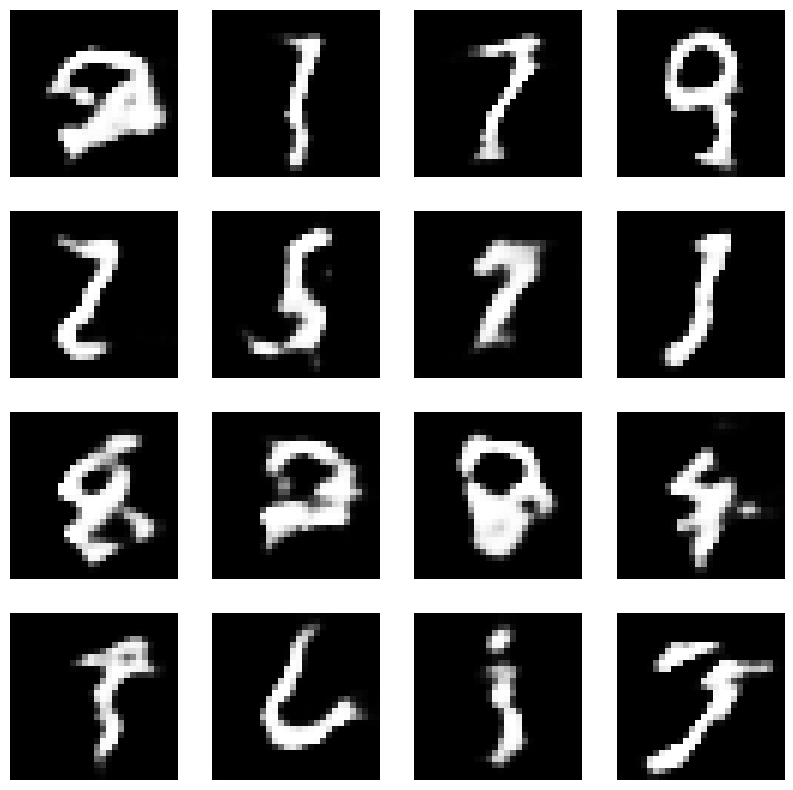

Epoch:  75


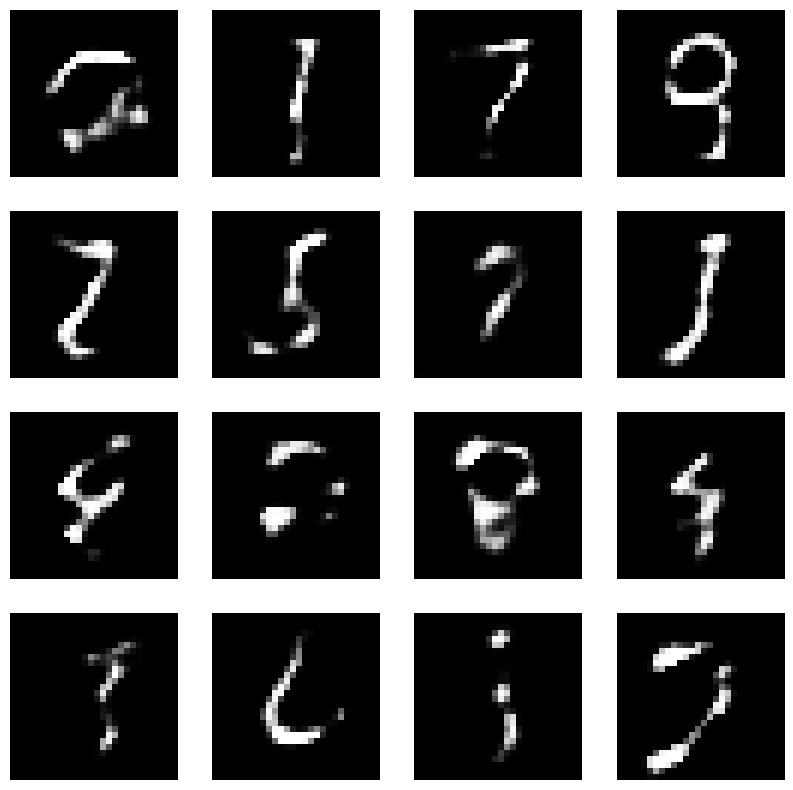

Epoch:  76


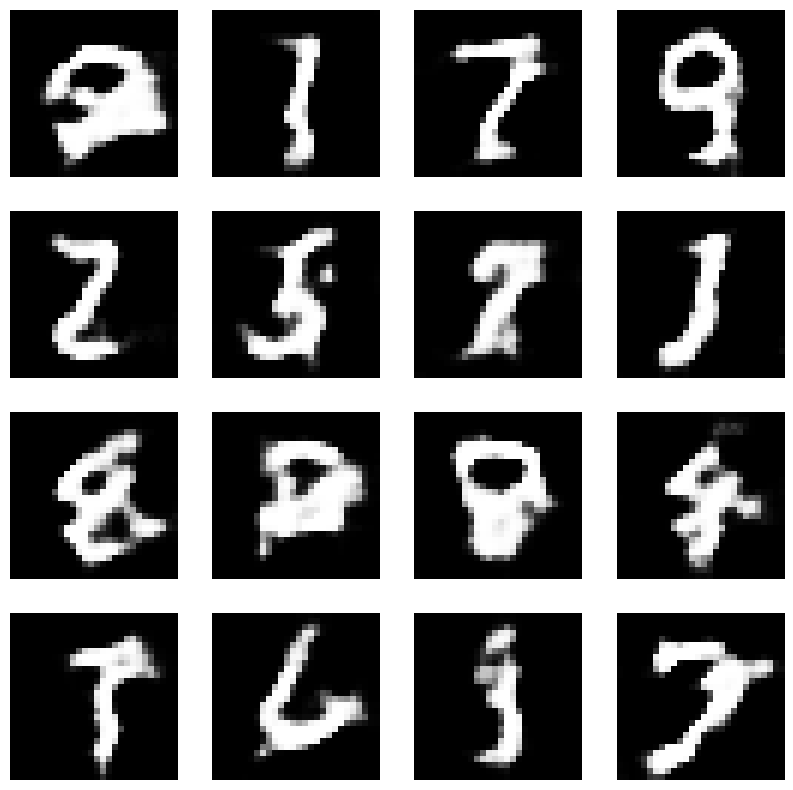

Epoch:  77


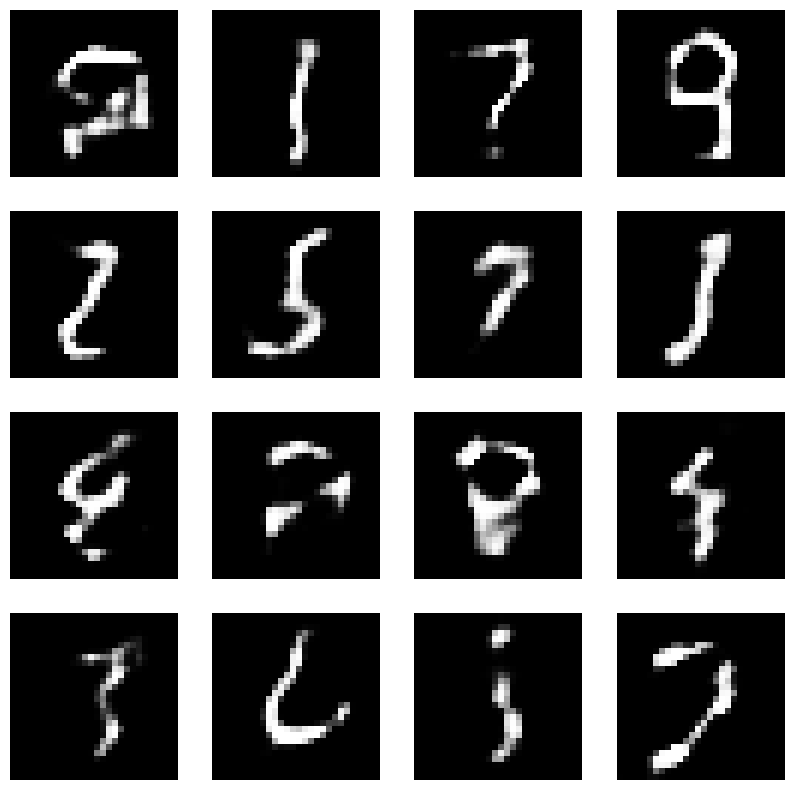

Epoch:  78


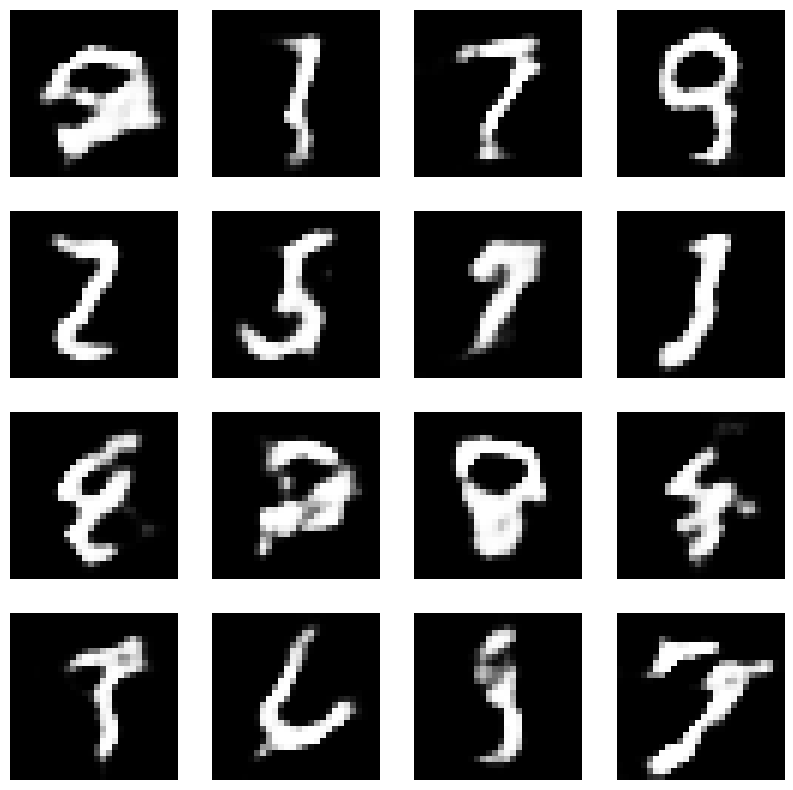

Epoch:  79


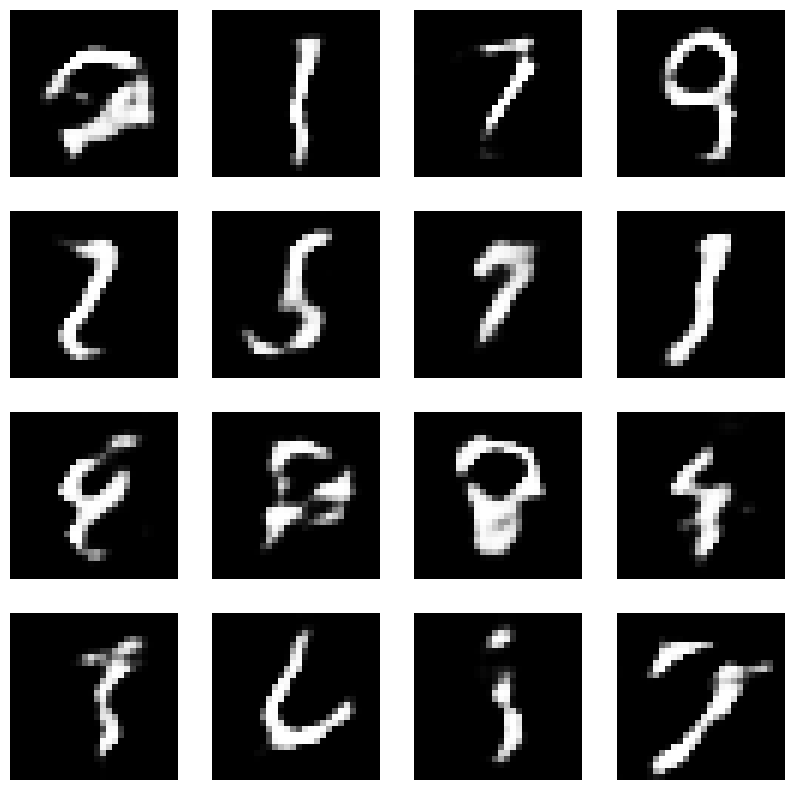

Epoch:  80


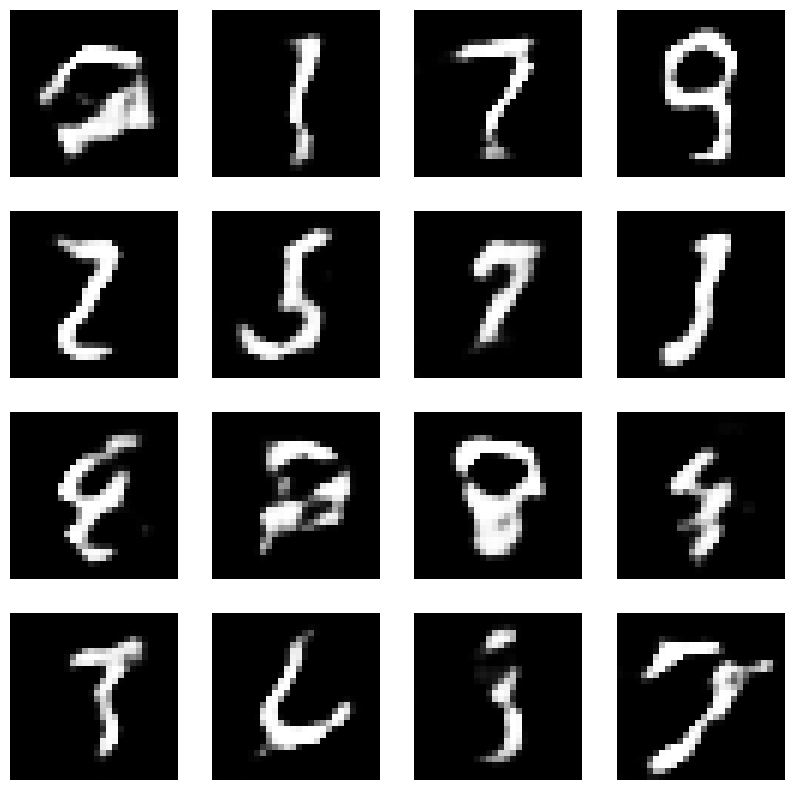

Epoch:  81


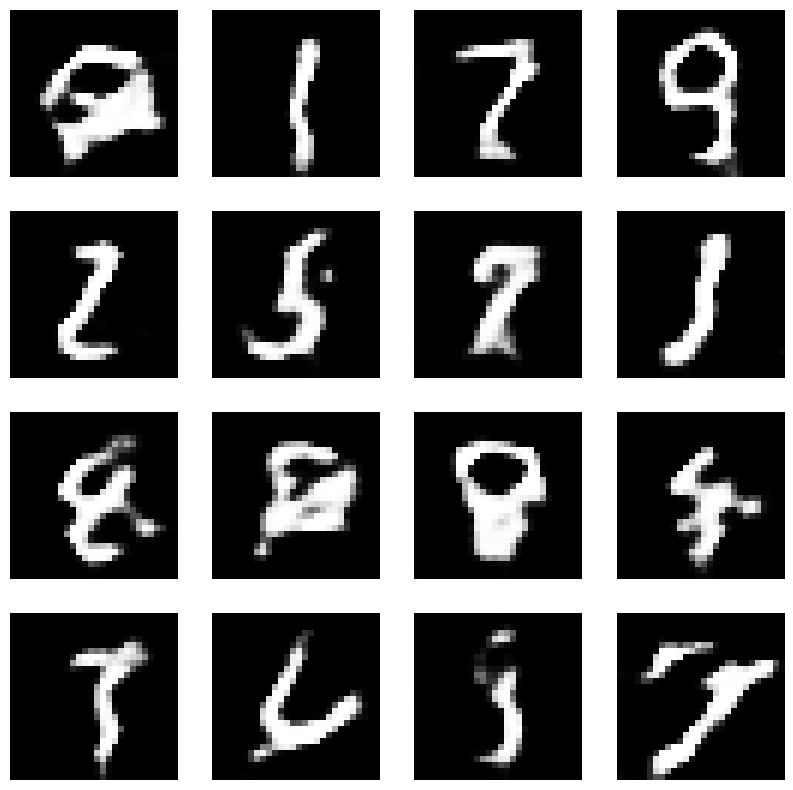

Epoch:  82


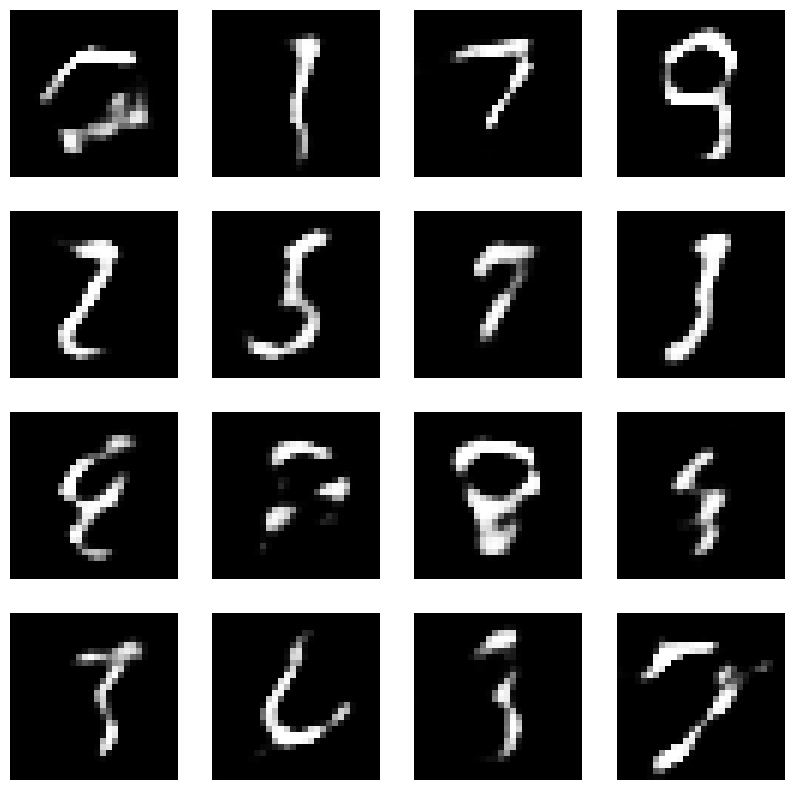

Epoch:  83


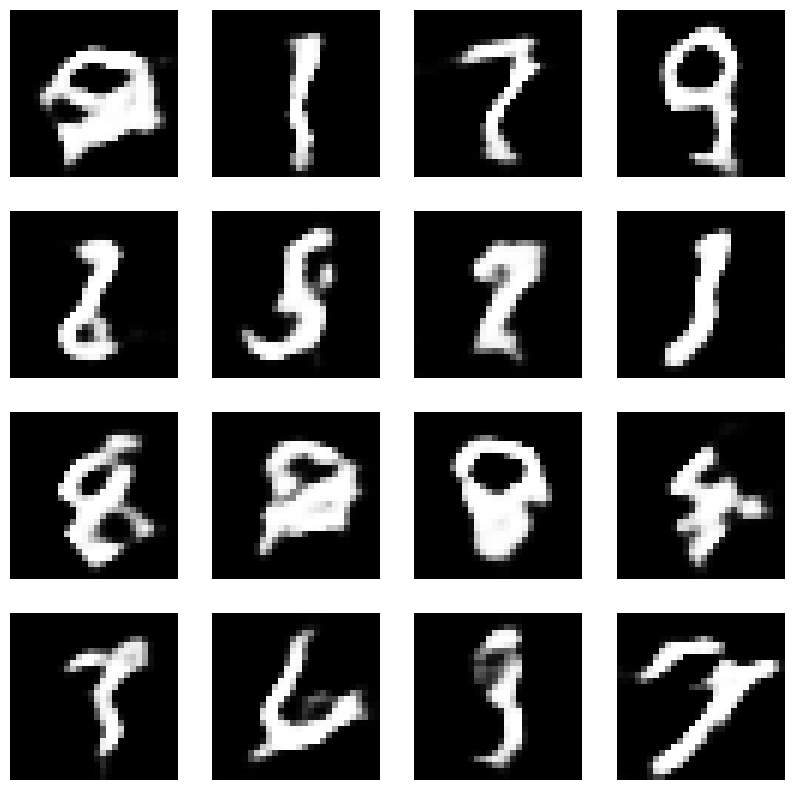

Epoch:  84


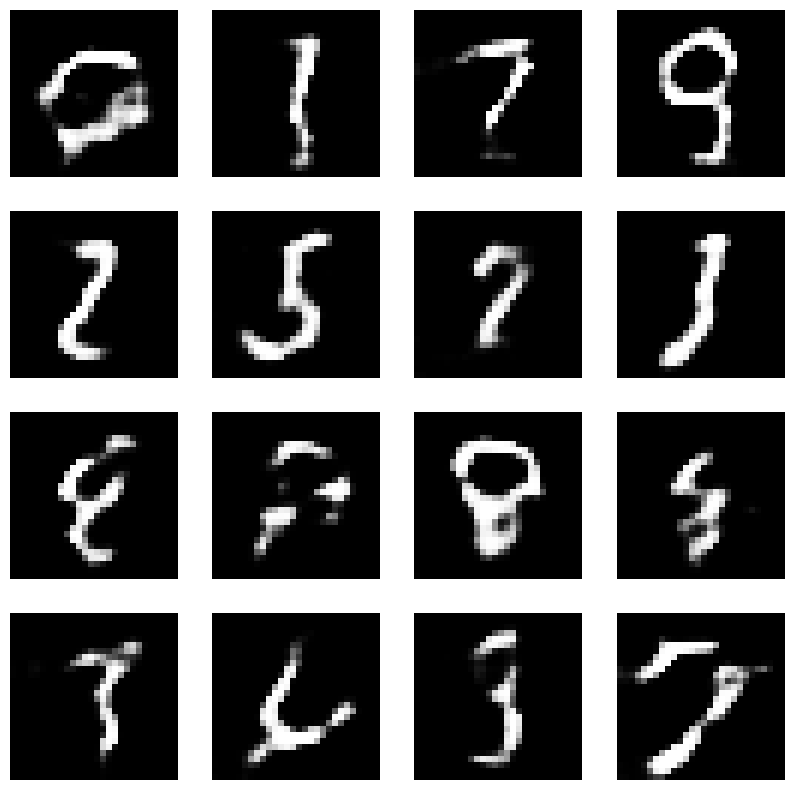

Epoch:  85


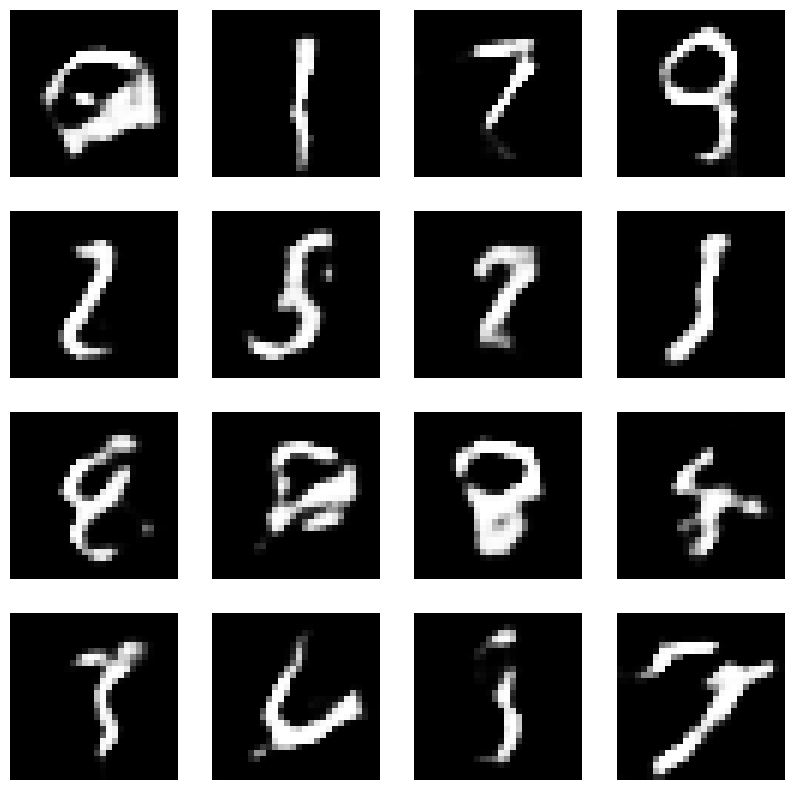

Epoch:  86


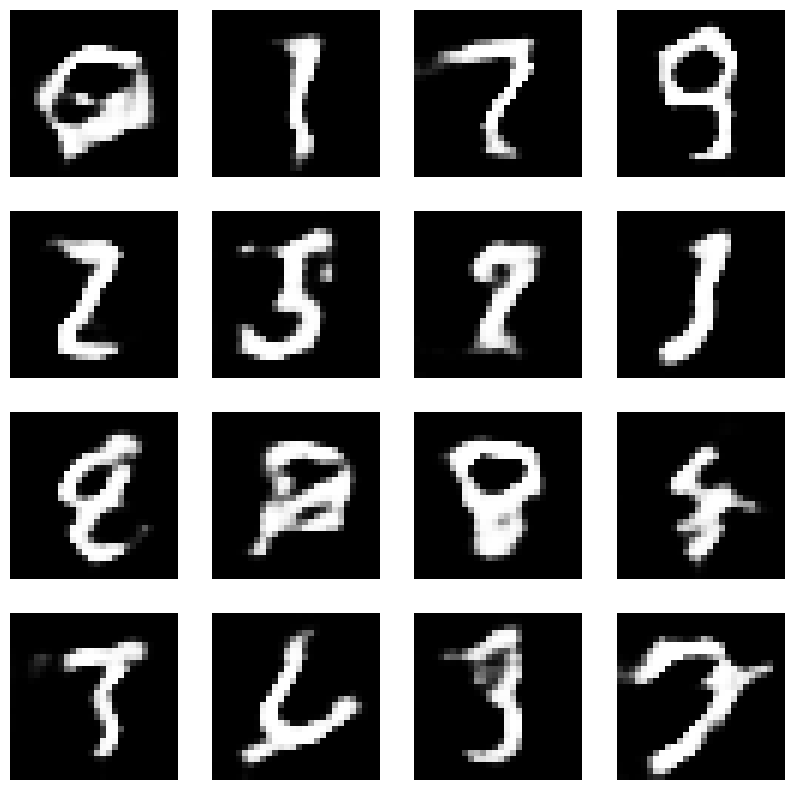

Epoch:  87


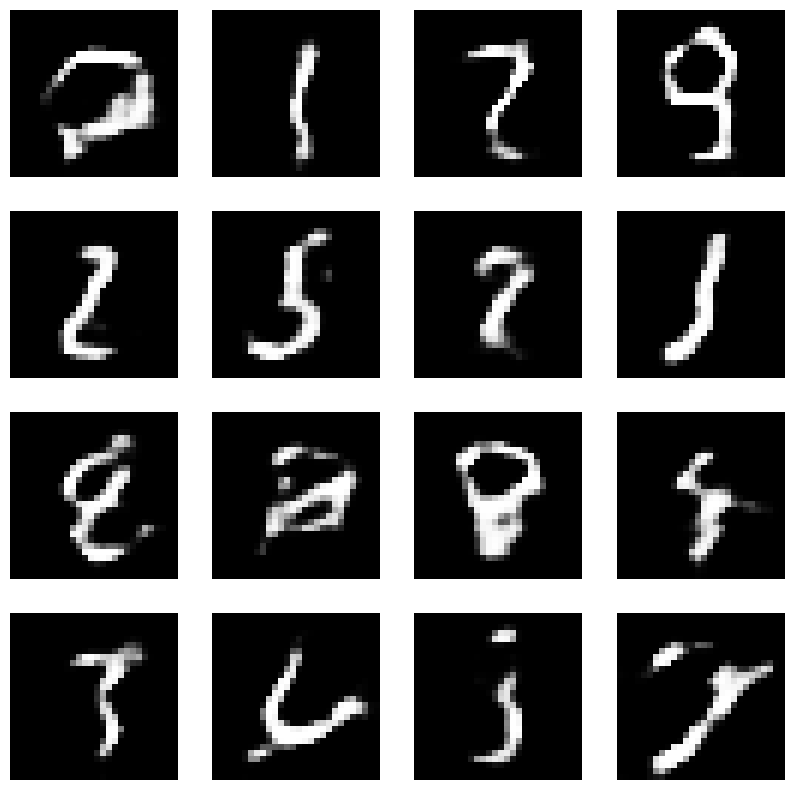

Epoch:  88


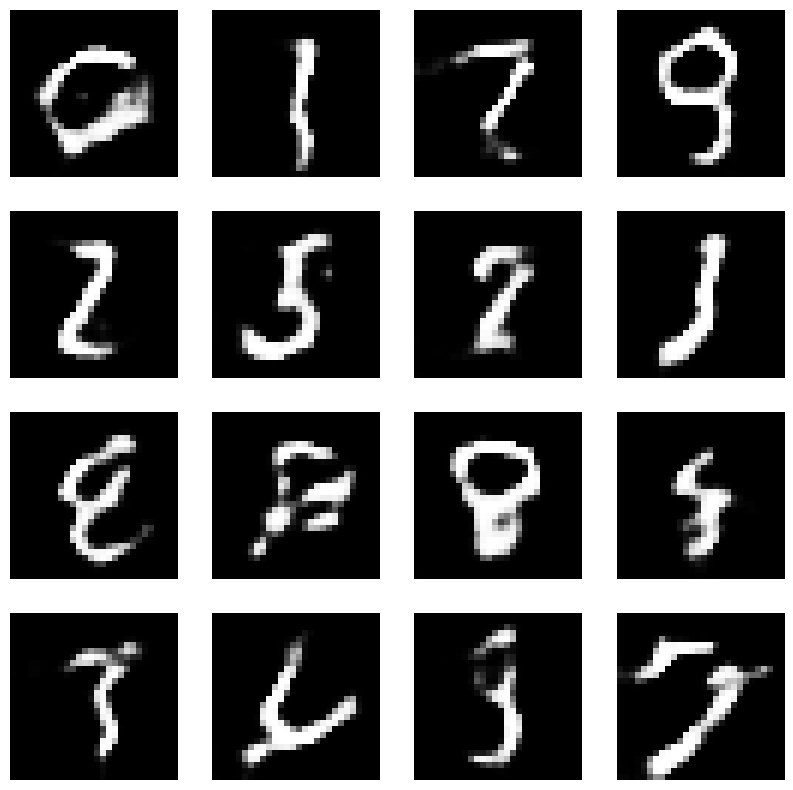

Epoch:  89


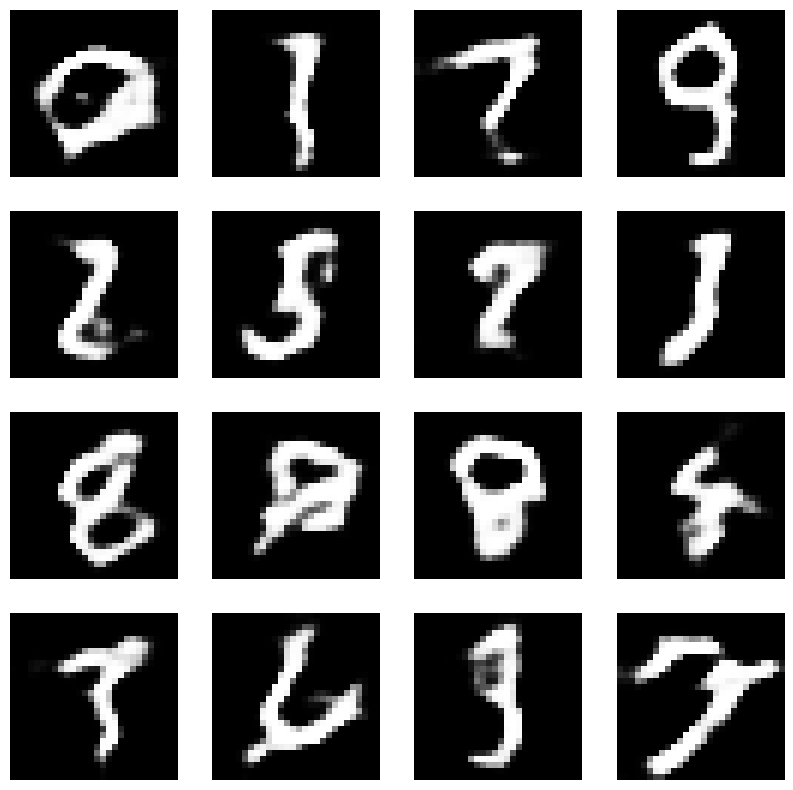

Epoch:  90


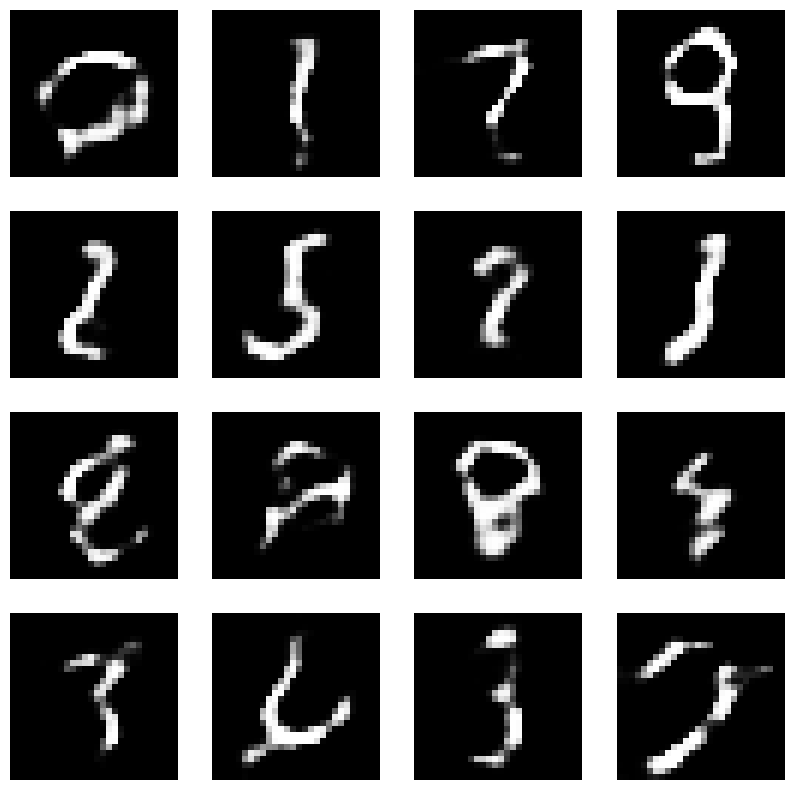

Epoch:  91


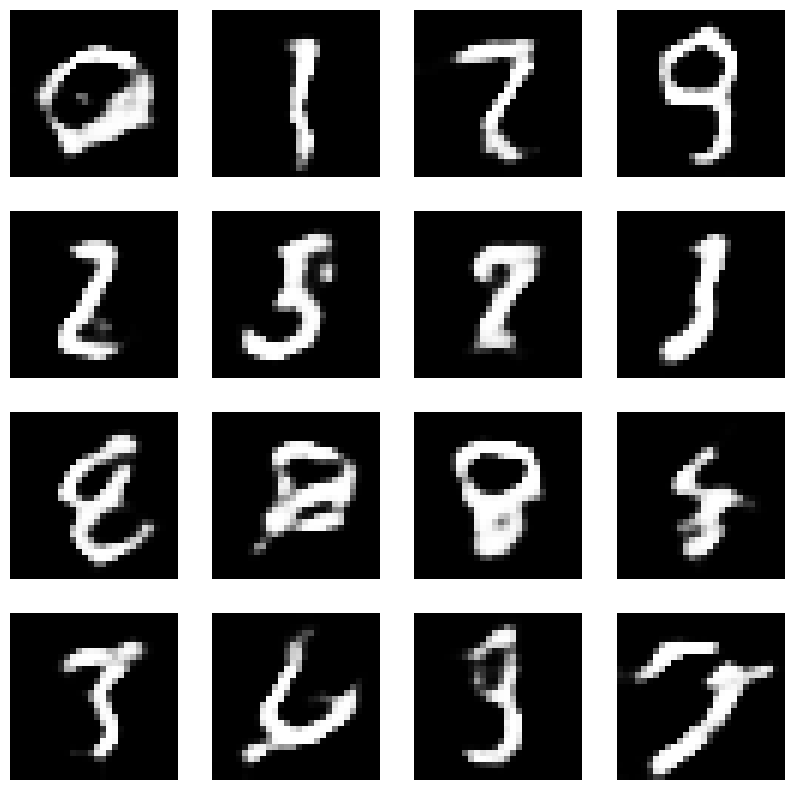

Epoch:  92


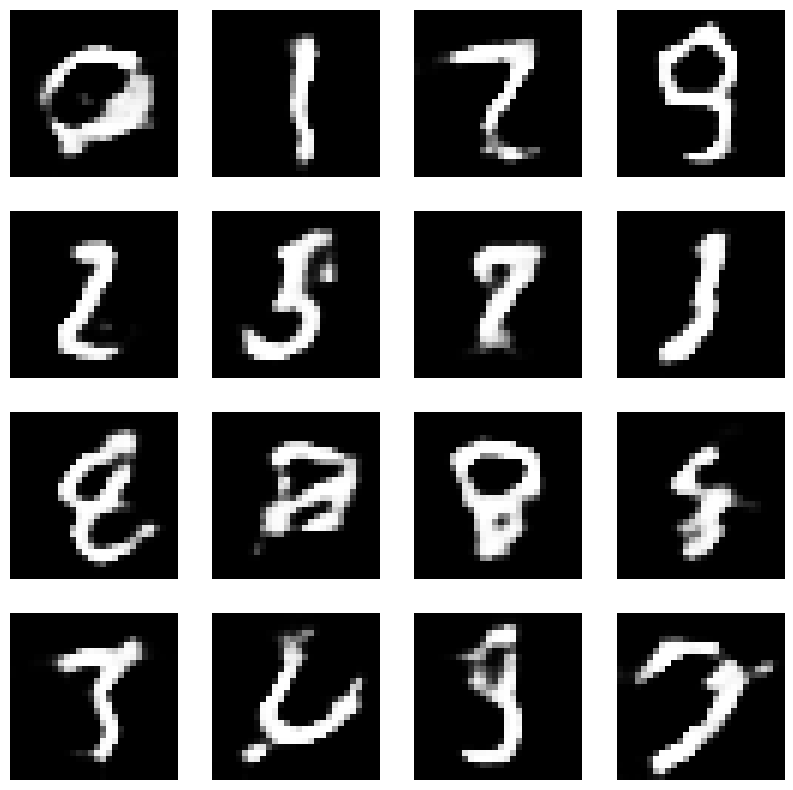

Epoch:  93


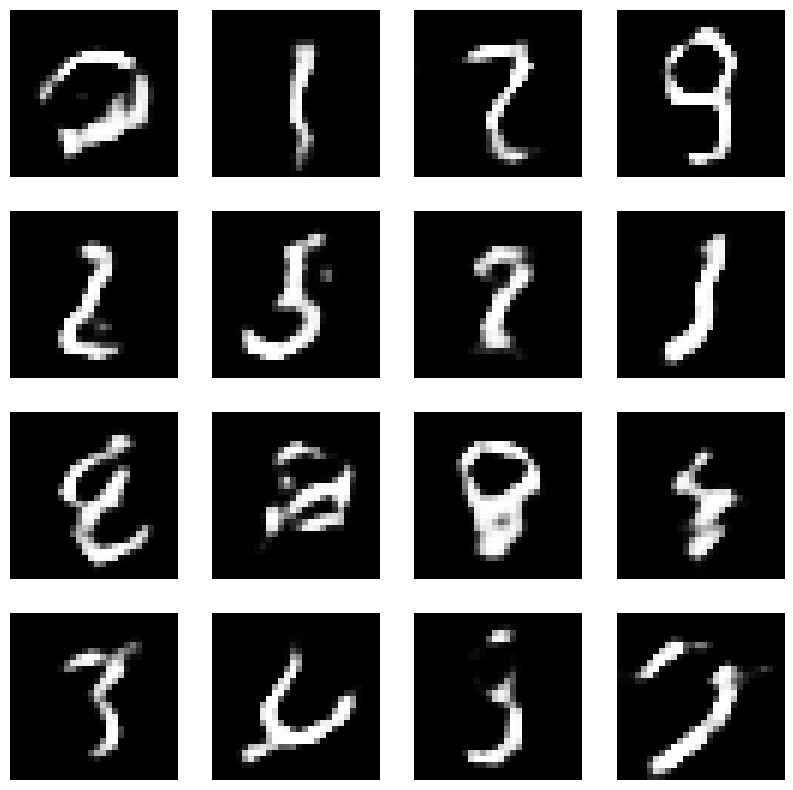

Epoch:  94


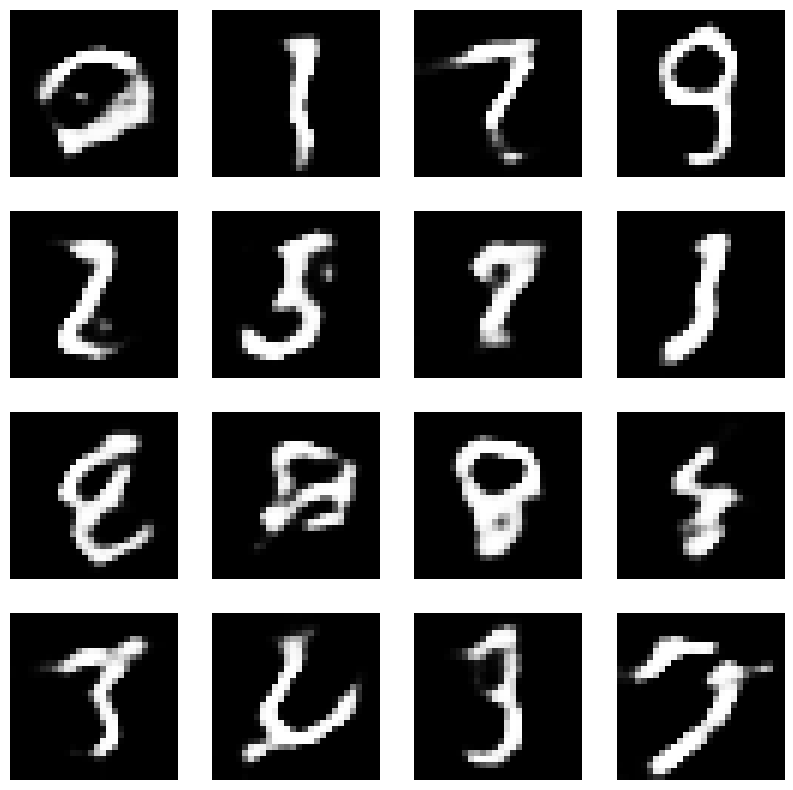

Epoch:  95


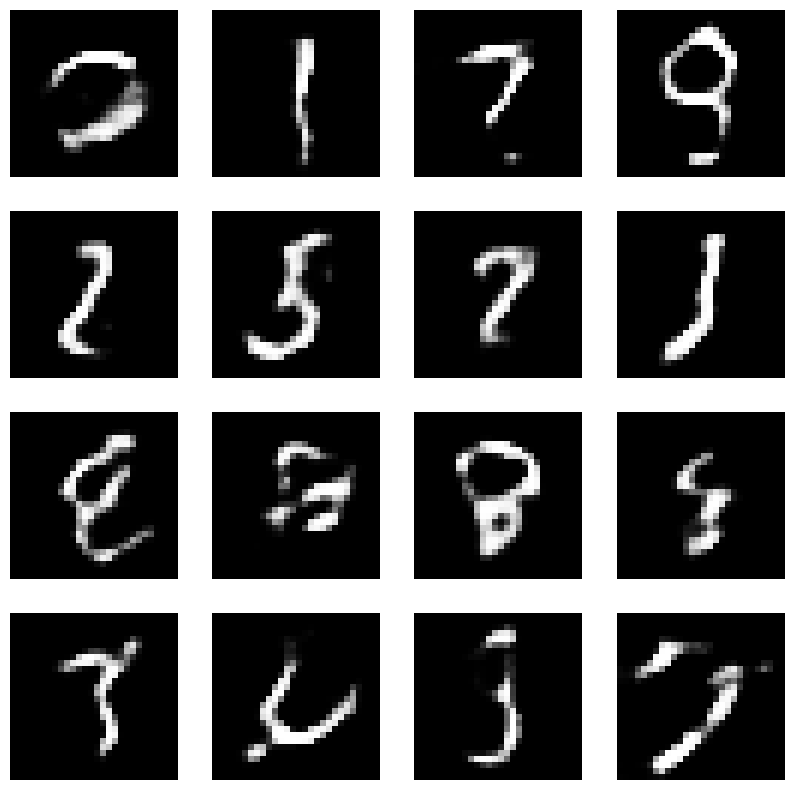

Epoch:  96


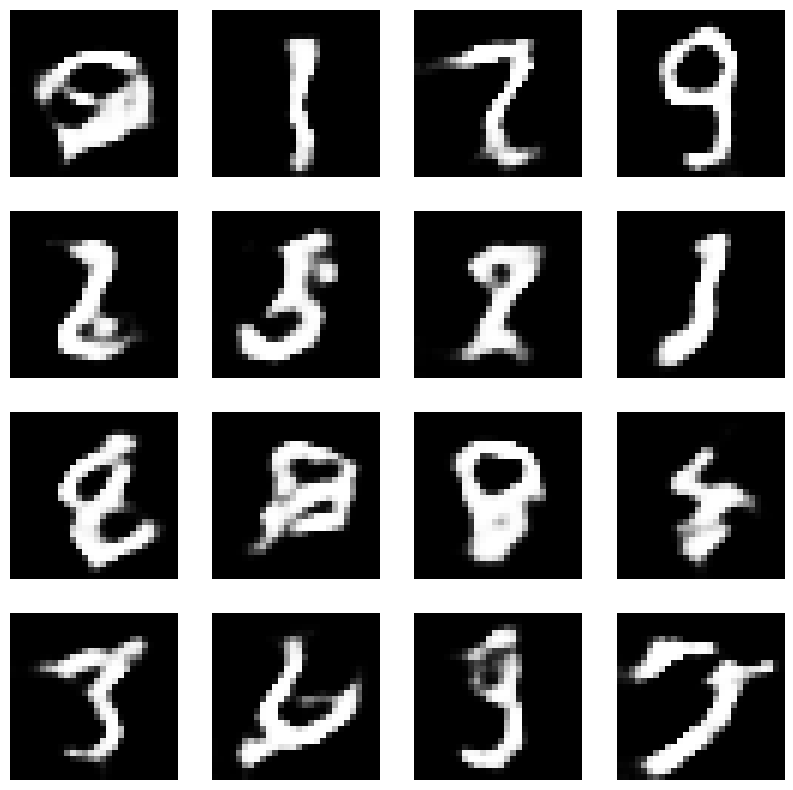

Epoch:  97


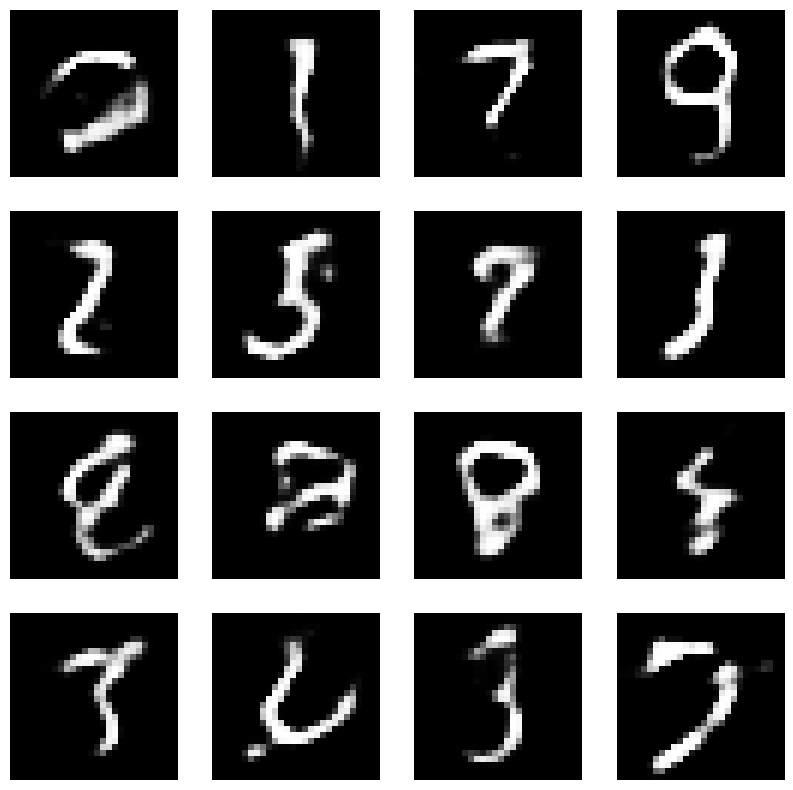

Epoch:  98


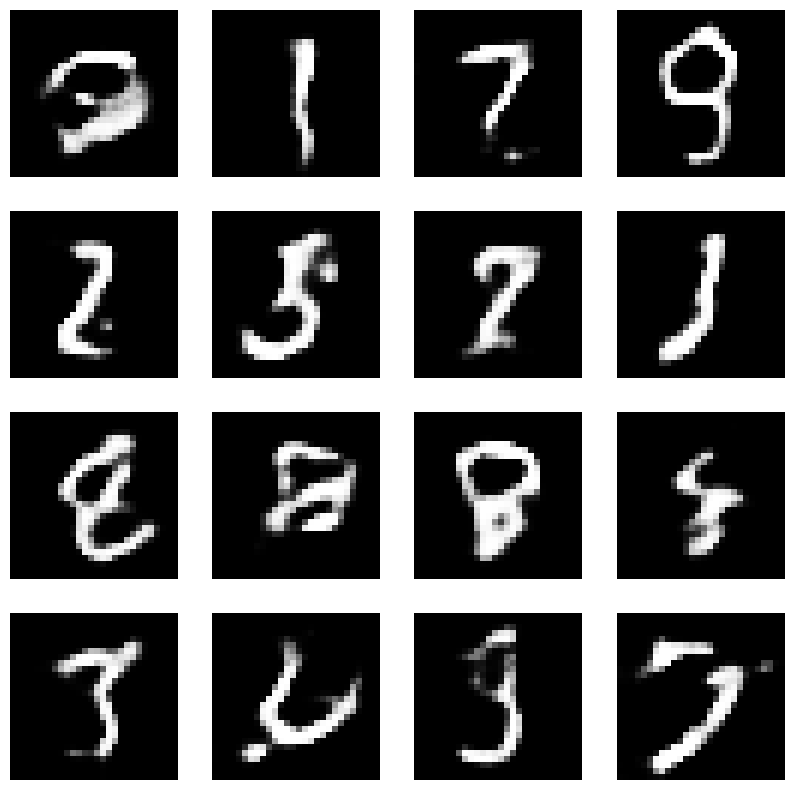

Epoch:  99


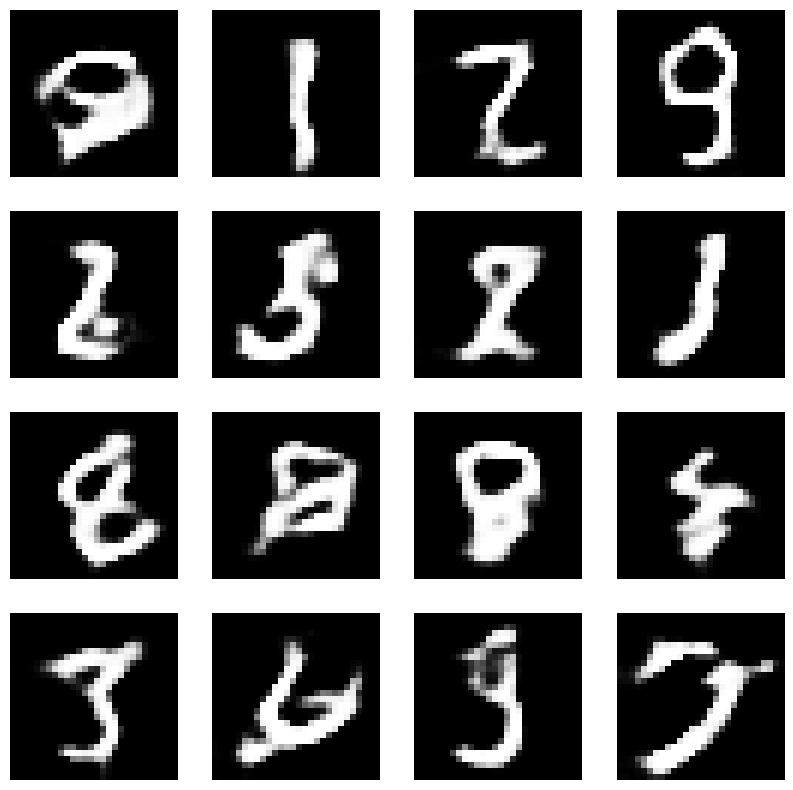

Epoch:  100


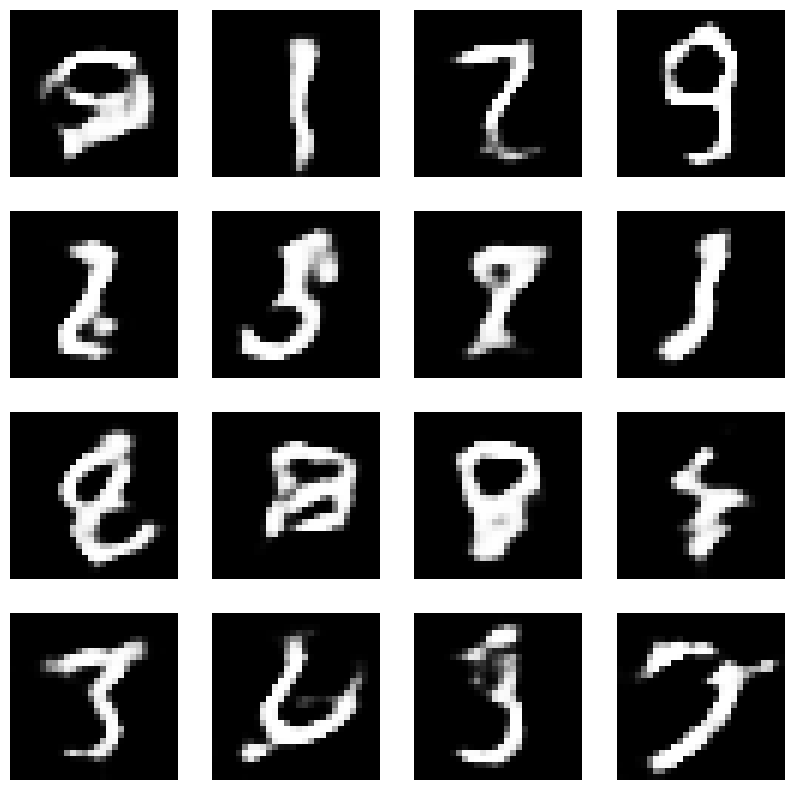

In [40]:
train_gan(X_train, epochs, test_images)